# Project Milestone 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gzip
import unicodedata
import re
import csv
import os 
import io
#import pycld2 as cld2
import pycountry as py 
import pycountry_convert as pc 
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.wkt import loads
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer


In [15]:
# Importations of our low-level methods 
from implementations import *

In [3]:
# Ignore a recurrent error
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

---
## Importing datasets


In [4]:
current_dir = os.getcwd()
parent_folder_path = os.path.abspath(os.path.join(current_dir, ".."))
data_path = os.path.join(parent_folder_path, "data")

path_ba = data_path + '/BeerAdvocate'
path_rb = data_path + '/RateBeer'
path_mbd = data_path + '/matched_beer_data'

beers_ba = pd.read_csv(f"{path_ba}/{'beers.csv'}")
users_ba = pd.read_csv(f"{path_ba}/{'users.csv'}")
breweries_ba = pd.read_csv(f"{path_ba}/{'breweries.csv'}")

beers_rb = pd.read_csv(f"{path_rb}/{'beers.csv'}")
users_rb = pd.read_csv(f"{path_rb}/{'users.csv'}")
breweries_rb = pd.read_csv(f"{path_rb}/{'breweries.csv'}")  

ratings_mbd = pd.read_csv(f"{path_mbd}/{'ratings.csv'}", header = 1)  
beers_mbd = pd.read_csv(f"{path_mbd}/{'beers.csv'}", header = 1) 
breweries_mbd = pd.read_csv(f"{path_mbd}/{'breweries.csv'}", header = 1) 
users_mbd = pd.read_csv(f"{path_mbd}/{'users.csv'}", header = 1) 

In [5]:
# Convert Beeradvocate reviews and ratings to csv 
txt_to_csv(path_ba,"reviews")
txt_to_csv(path_ba,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


In [6]:
# Convert RateBeer reviews and ratings to csv
txt_to_csv(path_rb,"reviews")
txt_to_csv(path_rb,"ratings")

reviews.csv is already present in the folder
ratings.csv is already present in the folder


We can see that reviews.txt and ratings.txt extracted from RateBeer are identicals text files simply because "*on RateBeer, you are required to write at least 75 characters describing the beer, and you must give it five different numeric ratings.*" In further analysis, we will simply use ratings.txt

In [5]:
# deep copies of all dataframes 
beers_ba_f = beers_ba.copy(deep=True)
users_ba_f = users_ba.copy(deep=True)
breweries_ba_f = breweries_ba.copy(deep=True)

beers_rb_f = beers_rb.copy(deep=True)
users_rb_f = users_rb.copy(deep=True)
breweries_rb_f = breweries_rb.copy(deep=True)

ratings_mbd_f = ratings_mbd.copy(deep=True)
breweries_mbd_f = breweries_mbd.copy(deep=True)
beers_mbd_f = beers_mbd.copy(deep=True)
users_mbd_f = users_mbd.copy(deep=True)

# 1.  Data observation 

In [12]:
display(beers_ba_f.head(4))
beers_ba_f.shape

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN


(280823, 15)

In [13]:
display(beers_rb_f.head(4))
beers_rb_f.shape

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667


(442081, 14)

In [14]:
display(breweries_ba_f.head(4))
breweries_ba_f.shape

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4


(16758, 4)

In [15]:
display(breweries_rb_f.head(4))
breweries_rb_f.shape

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66


(24189, 4)

In [16]:
display(users_ba_f.head(4))
users_ba_f.shape

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland


(153704, 6)

In [17]:
display(users_rb_f.head(4))
users_rb_f.shape

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain


(70174, 5)

### Reviews.csv and Ratings.csv datasets

In [18]:
reviews_ba = pd.read_csv(f"{path_ba}/reviews.csv", nrows=100)
reviews_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....."


In [19]:
ratings_ba = pd.read_csv(f"{path_ba}/ratings.csv", nrows=100)
ratings_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True


In [20]:
reviews_rb = pd.read_csv(f"{path_rb}/reviews.csv", nrows=100)
reviews_rb.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."


In [21]:
ratings_rb = pd.read_csv(f"{path_rb}/ratings.csv", nrows=100)
ratings_rb.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."


### Looking for NaN

In [22]:
beers_ba_f.isna().sum()

beer_id                           0
beer_name                         0
brewery_id                        0
brewery_name                      0
style                             0
nbr_ratings                       0
nbr_reviews                       0
avg                           32829
ba_score                     219623
bros_score                   275121
abv                           36024
avg_computed                  32841
zscore                       240538
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    252551
dtype: int64

In [23]:
beers_rb_f.isna().sum()

beer_id                           0
beer_name                         0
brewery_id                        0
brewery_name                      0
style                             0
nbr_ratings                       0
overall_score                338053
style_score                  338013
avg                           46424
abv                           42094
avg_computed                  45391
zscore                       399853
nbr_matched_valid_ratings         0
avg_matched_valid_ratings    399853
dtype: int64

In [24]:
breweries_ba_f.isna().sum()

id           0
location     0
name         0
nbr_beers    0
dtype: int64

In [25]:
breweries_rb_f.isna().sum()

id           0
location     0
name         0
nbr_beers    0
dtype: int64

In [26]:
users_ba_f.isna().sum()

nbr_ratings        0
nbr_reviews        0
user_id            0
user_name          1
joined          2652
location       31279
dtype: int64

In [27]:
users_rb_f.isna().sum()

nbr_ratings        0
user_id            0
user_name          0
joined            30
location       19582
dtype: int64

### Matched beer data files 

In [28]:
print('Size of beers file: ', beers_mbd_f.shape)
print('Size of breweries file: ', breweries_mbd_f.shape)
print('Size of users file: ', users_mbd_f.shape)

Size of beers file:  (45640, 33)
Size of breweries file:  (8281, 10)
Size of users file:  (3020, 13)


Noticing the small size of the matched beer data files compared to the individual files for RateBbeer and BeerAdvocate, we decide to study the other files instead if these the matched ones. 

# 2. Basic metrics to measure the trend of a beer 

In this part we will have a look at different variables such as the number of ratings, the styles of beers, the scores, the average across all ratings. First, we will have a look at them individually and see if there are any correlations between them. Secondly, we will study them regarding the location variable. 

### Number of ratings 

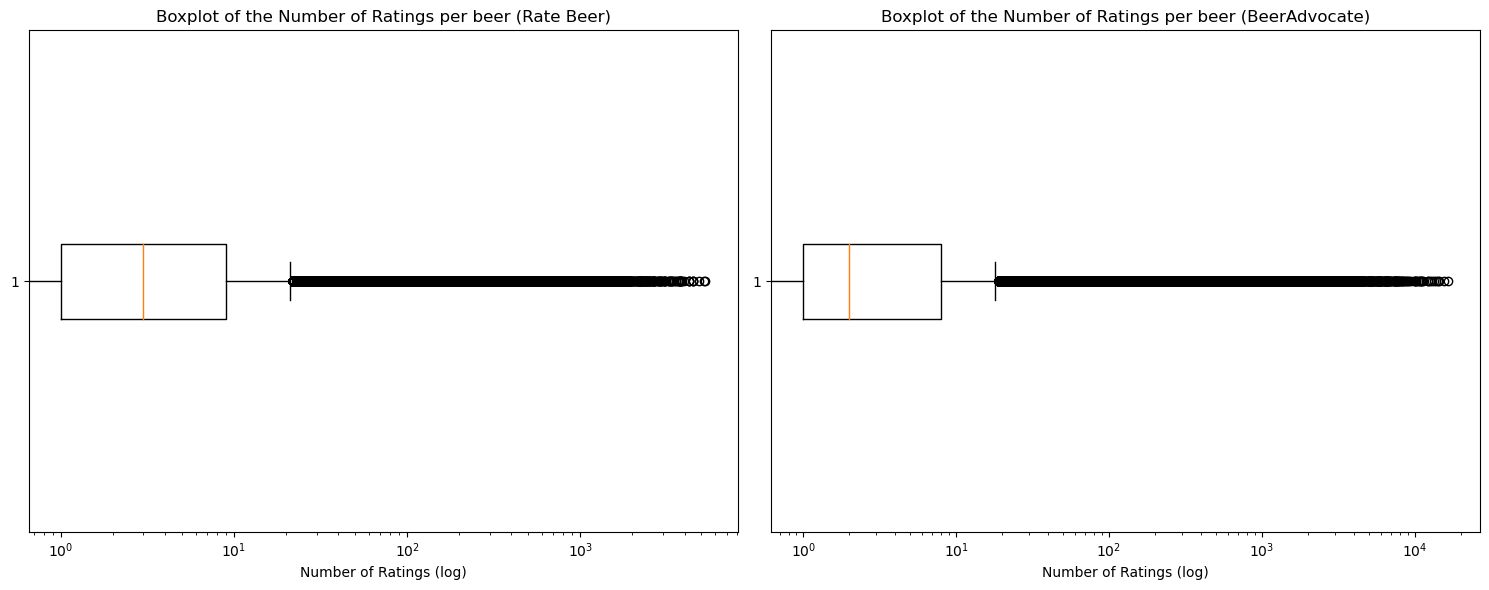

In [29]:
# Number of ratings per beer 
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.boxplot(beers_rb_f['nbr_ratings'], vert=False)
plt.title('Boxplot of the Number of Ratings per beer (Rate Beer)')
plt.xlabel('Number of Ratings (log)')
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.boxplot(beers_ba_f['nbr_ratings'], vert=False)
plt.title('Boxplot of the Number of Ratings per beer (BeerAdvocate)')
plt.xlabel('Number of Ratings (log)')
plt.xscale('log')

plt.tight_layout()
plt.show()

As we can see the mean number of ratings per beer for both sites is pretty low. However, there are a lot of beers that receives a huge number of ratings on both sites, suggesting that some beers stand out from others. 

### Styles of beer

In [30]:
# Number of styles of beers 
nbr_style_ba = beers_ba_f['style'].value_counts().nlargest(15)
nbr_style_rb = beers_rb_f['style'].value_counts().nlargest(15)
nbr_style_mbd = ratings_mbd_f['style'].value_counts().nlargest(15)

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/520668701.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


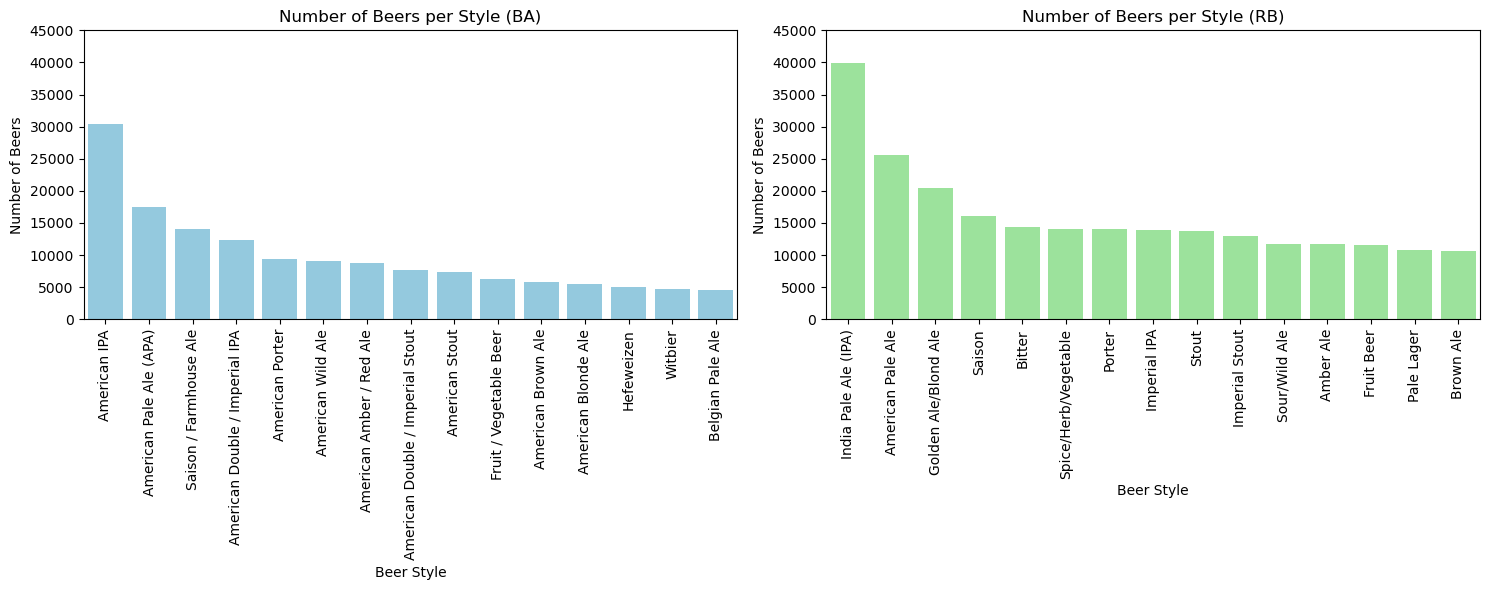

In [31]:
plt.figure(figsize=(15, 6))

# Number of styles of beers for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x=nbr_style_ba.index, y=nbr_style_ba.values, color='skyblue')
plt.title('Number of Beers per Style (BA)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

# Number of styles of beers for RateBeer
plt.subplot(1, 2, 2)
sns.barplot(x=nbr_style_rb.index, y=nbr_style_rb.values, color='lightgreen')
plt.title('Number of Beers per Style (RB)')
plt.xlabel('Beer Style')
plt.ylabel('Number of Beers')
plt.xticks(rotation=90)
plt.ylim(0, 45000)
plt.tight_layout()

plt.show()

As we can see the two most represented styles on both sites are IPA beers. 

### Number of ratings per style of beer

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/395818329.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


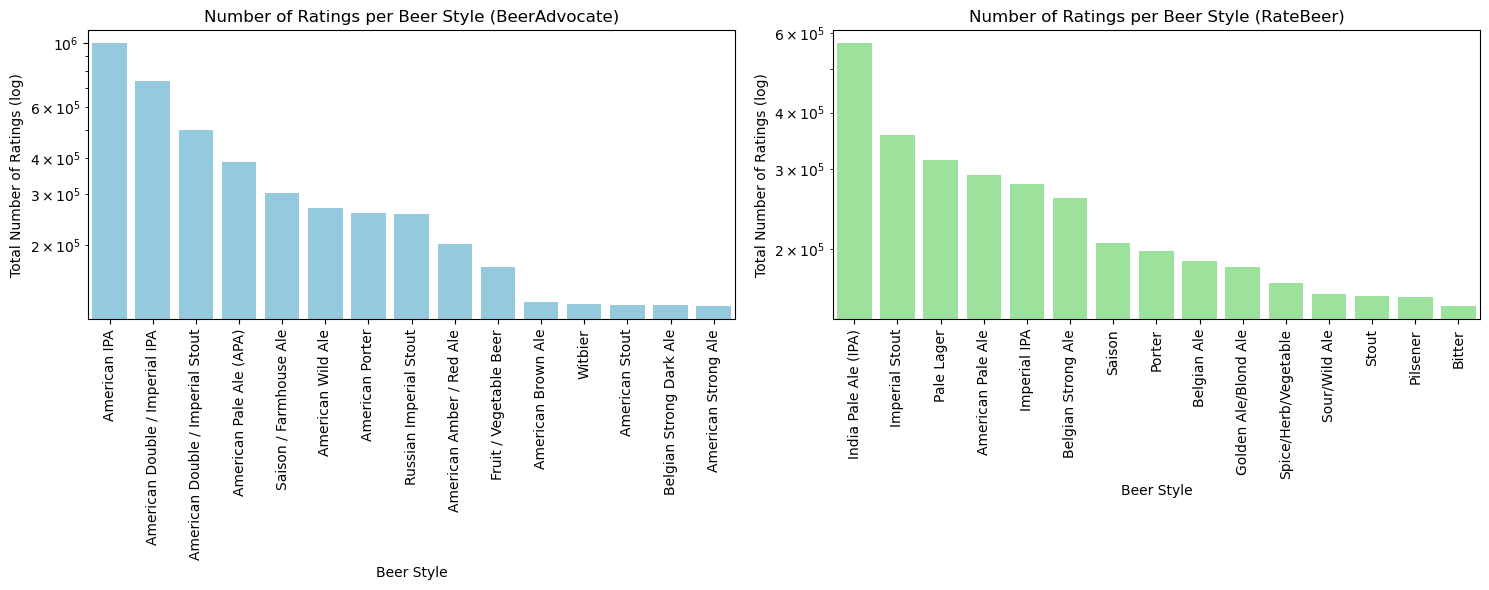

In [32]:
# Number of ratings per beer style for BeerAdvocate
ba_ratings_style = beers_ba_f[['style', 'nbr_ratings']].groupby('style').sum().reset_index()
ba_ratings_style = ba_ratings_style.sort_values(by='nbr_ratings', ascending=False)
ba_ratings_style= ba_ratings_style.nlargest(15, 'nbr_ratings') # only select the 15 most rated beers 

# Number of ratings per beer style for RateBeer
rb_ratings_style = beers_rb_f[['style', 'nbr_ratings']].groupby('style').sum().reset_index()
rb_ratings_style = rb_ratings_style.sort_values(by='nbr_ratings', ascending=False)
rb_ratings_style= rb_ratings_style.nlargest(15, 'nbr_ratings') # only select the 15 most rated beers 

plt.figure(figsize=(15, 6))

# Plot for BeerAdvocate
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=ba_ratings_style, x='style', y='nbr_ratings', color='skyblue')
plt.title('Number of Ratings per Beer Style (BeerAdvocate)')
plt.xlabel('Beer Style')
plt.ylabel('Total Number of Ratings (log)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')  

# Plot for RateBeer
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=rb_ratings_style, x='style', y='nbr_ratings', color='lightgreen')
plt.title('Number of Ratings per Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Total Number of Ratings (log)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')  

plt.show()

As we can see the most rated beer style is a type of IPA for both sites. Overall, having a first look at the style variable we can see that IPAs are greatly represented on BeerAdvocate and on RateBeer. 

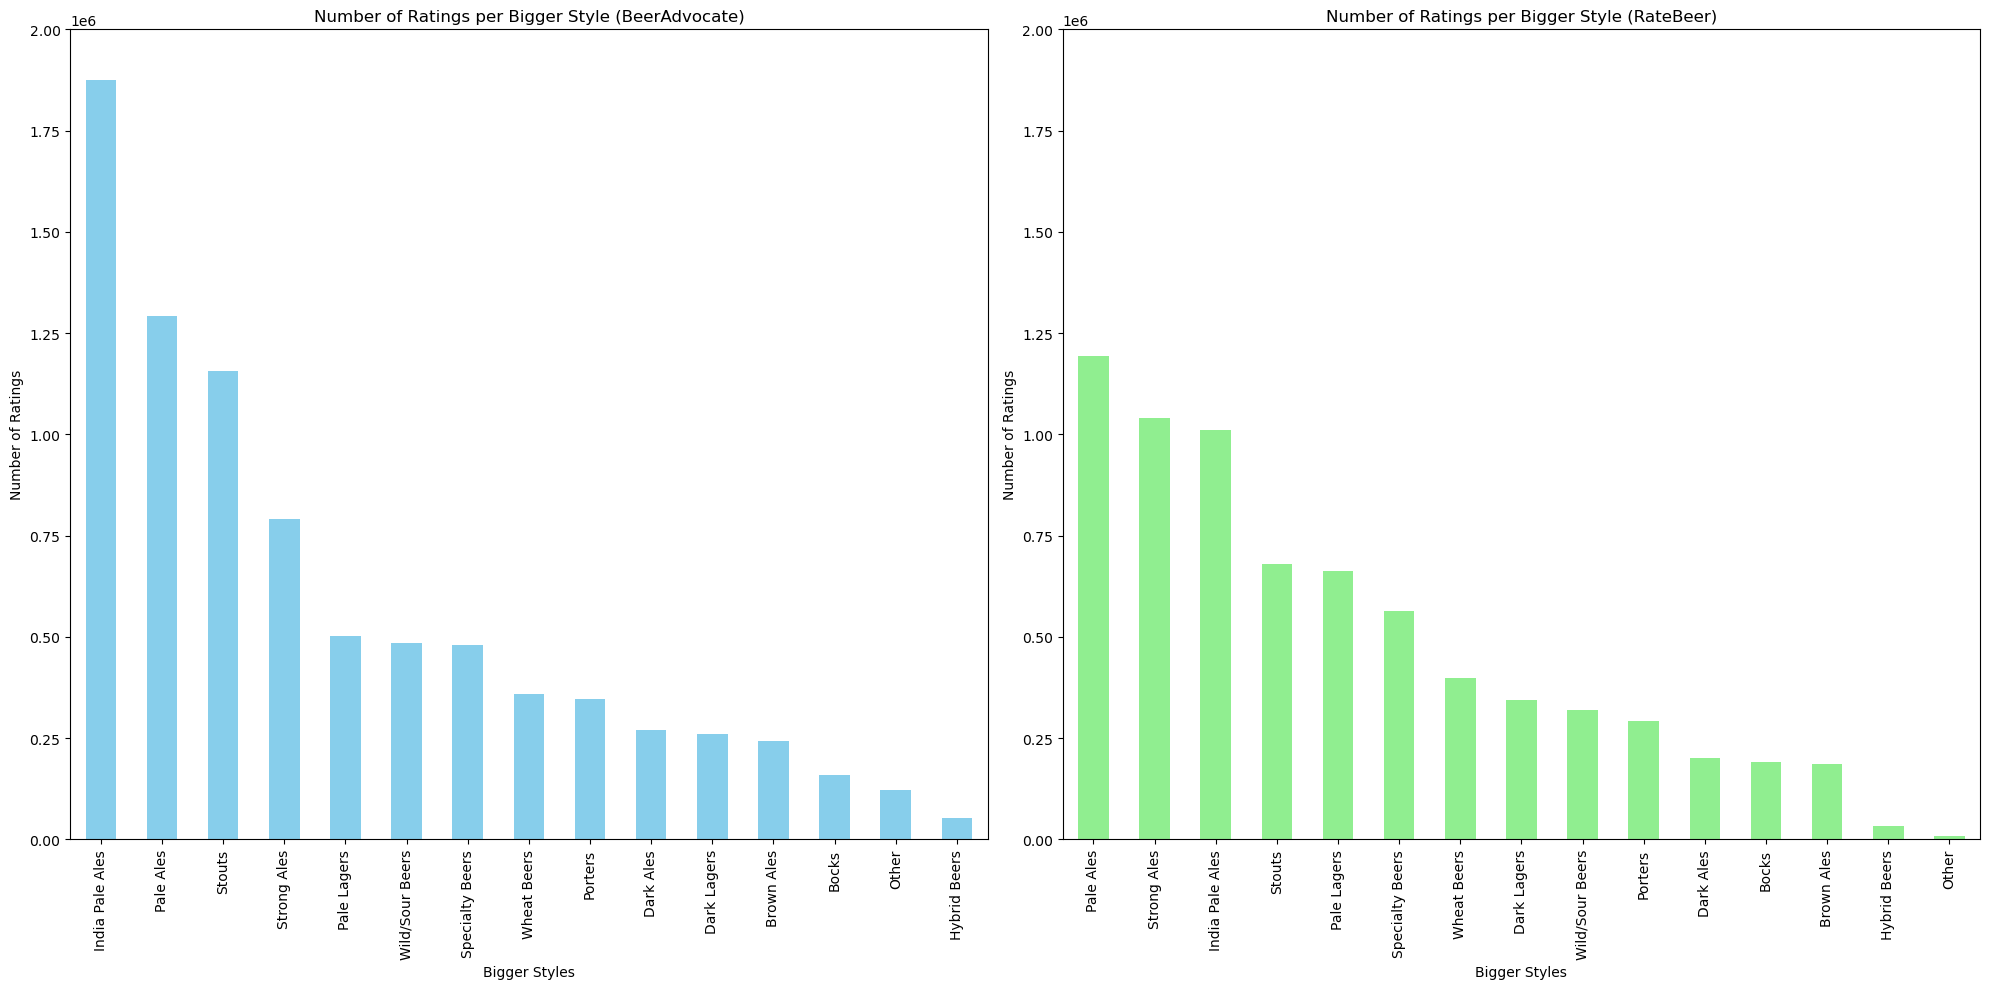

In [33]:
# Categorize each style with the Bigger styles of beer of each website 
beers_ba_f['bigger_style'] = beers_ba_f['style'].apply(categorize_style)
beers_rb_f['bigger_style'] = beers_rb_f['style'].apply(categorize_style)

ratings_per_bigger_style_ba = beers_ba_f.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)
ratings_per_bigger_style_rb = beers_rb_f.groupby('bigger_style')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(1,2,1)
ax1 = ratings_per_bigger_style_ba.plot(kind='bar', color='skyblue')
plt.title('Number of Ratings per Bigger Style (BeerAdvocate)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.ylim(0,2000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = ratings_per_bigger_style_rb.plot(kind='bar', color='lightgreen')
plt.title('Number of Ratings per Bigger Style (RateBeer)')
plt.xlabel('Bigger Styles')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.ylim(0,2000000)
plt.tight_layout()

plt.show()

Even when looking at a bigger picture, IPAs still are in the top 3 most rated beer style on both websites. Pales Ales, Stout and Strong Ales are also greatly represented on the websites. 

### Scores 

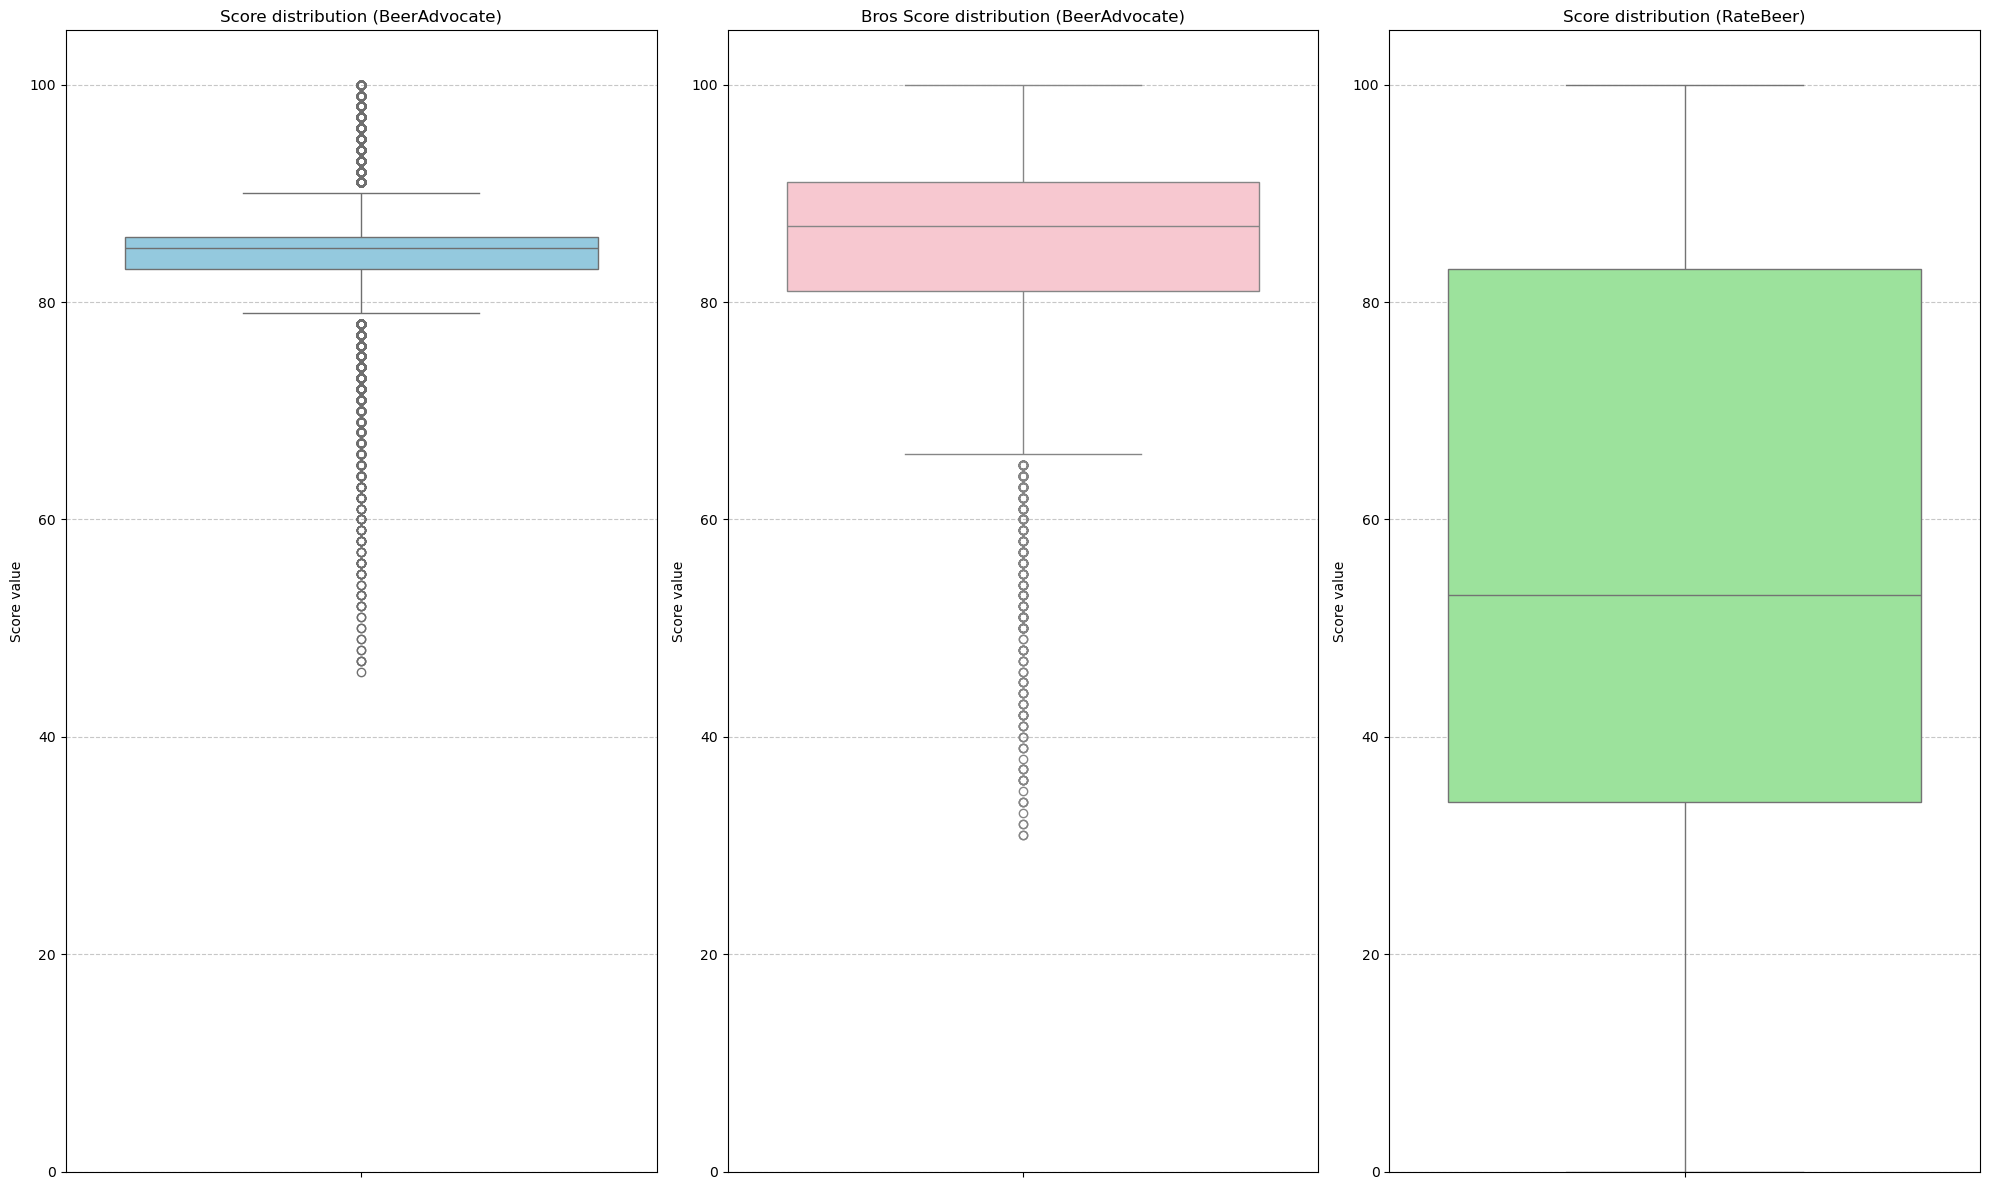

In [34]:
# Drop NA values for the scores 
beers_ba_f['ba_score'].dropna()
beers_rb_f['overall_score'].dropna()
beers_ba_f['bros_score'].dropna()

ba_score_count = beers_ba_f['ba_score'].value_counts()
rb_score_count = beers_rb_f['overall_score'].value_counts()
bros_score_count = beers_ba_f['bros_score'].value_counts()

plt.figure(figsize=(20, 12))
plt.subplot(1, 3, 1)
ax1 = sns.boxplot(beers_ba_f['ba_score'], color='skyblue')
plt.title('Score distribution (BeerAdvocate)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(beers_ba_f['bros_score'], color='pink')
plt.title('Bros Score distribution (BeerAdvocate)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(beers_rb_f['overall_score'], color='lightgreen')
plt.title('Score distribution (RateBeer)')
plt.ylabel('Score value')
plt.ylim(0,105)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

As we can see, beers on BeerAdvocate tend to have higher ratings than beers on RateBeer, which have more spread-out ratings. This is because BeerAdvocate's algorithm for calculating the score is a little different from RateBeer's algorithm. The former uses a custom Bayesian fomula, while the latter uses a true Bayesian estimate formula. [Score explanation BeerAdvocate](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/) & [Score explanation for RateBeer](https://www.ratebeer.com/our-scores)

The bros score on BeerAdvocate, which is the score that the founders of the website (so experts) give to the beers, can be a good metric to help us find define a trend. Indeed, we can see that the bros score is more spread out which might be a more accurate representation of the quality of the beer. This metric is only available on Beer Advocate.
Generally, people say they value the bros score when there score is above the average for less popular styles. It is something we must keep in mind for further analysis [Forum BA](https://link-url-here.org)

### Average score per style 

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/3452989156.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


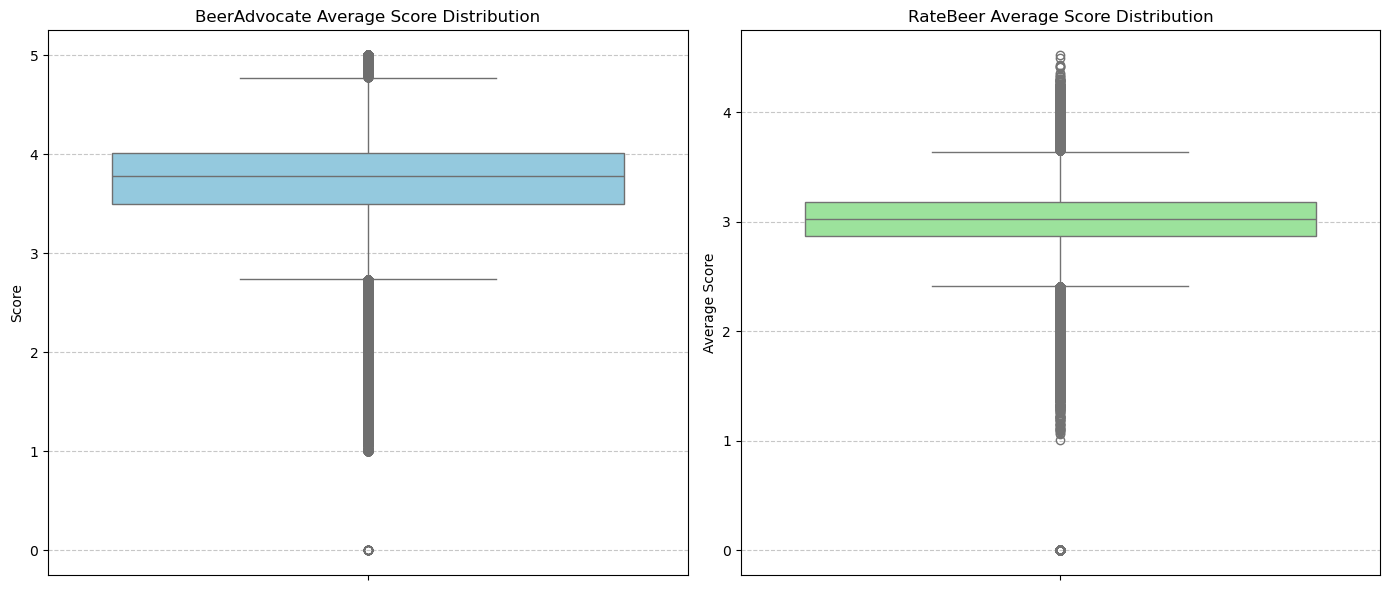

In [35]:
# Drop NA values for the average scores 
beers_ba_f['avg'].dropna()
beers_rb_f['avg'].dropna()

# Distribution of the average score 
plt.figure(figsize=(14, 6))

# Boxplot for BeerAdvocate
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(y=beers_ba_f['avg'], color='skyblue')
plt.title('BeerAdvocate Average Score Distribution')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Boxplot for RateBeer
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(y=beers_rb_f['avg'], color='lightgreen')
plt.title('RateBeer Average Score Distribution')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

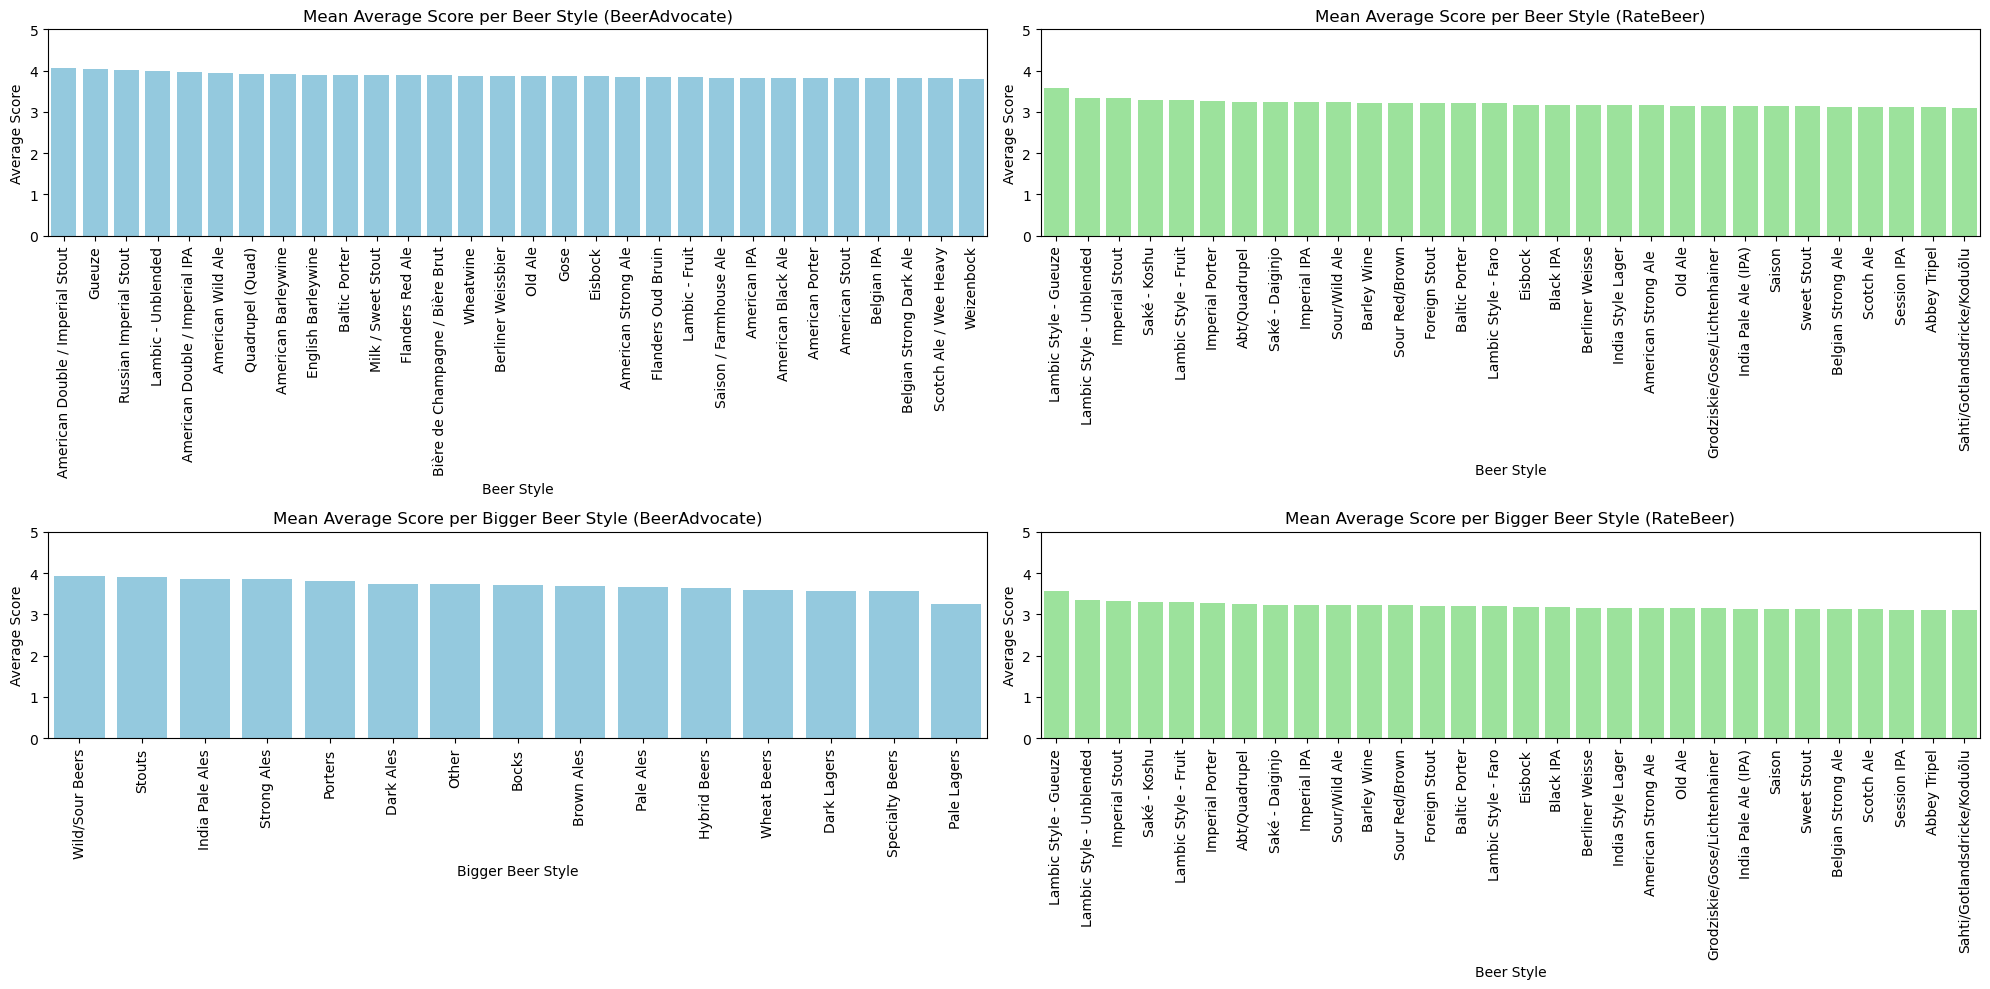

In [36]:
# Average score per style for BeerAdvocate 
ba_avg_style = beers_ba_f[['style', 'avg']].groupby('style').mean().reset_index()
ba_avg_style = ba_avg_style.sort_values(by='avg', ascending=False)
ba_avg_style = ba_avg_style.nlargest(30, 'avg') # only choosing the 30 largets mean average for better visualization 

# Average score per style for RateBeer
rb_avg_style = beers_rb_f[['style', 'avg']].groupby('style').mean().reset_index()
rb_avg_style = rb_avg_style.sort_values(by='avg', ascending=False)
rb_avg_style = rb_avg_style.nlargest(30, 'avg') # only choosing the 30 largets mean average for better visualization 

# Average score per bigger style for BeerAdvocate 
ba_avg_per_bigger_style = beers_ba_f[['bigger_style', 'avg']].groupby('bigger_style').mean().reset_index()
ba_avg_per_bigger_style = ba_avg_per_bigger_style.sort_values(by='avg', ascending=False)

# Average score per bigger style for RateBeer 
rb_avg_per_bigger_style = beers_rb_f[['bigger_style', 'avg']].groupby('bigger_style').mean().reset_index()
rb_avg_per_bigger_style = rb_avg_per_bigger_style.sort_values(by='avg', ascending=False)

plt.figure(figsize=(20, 10))

# Plot for BeerAdvocate
plt.subplot(2,2,1)
ax1 = sns.barplot(data=ba_avg_style, x='style', y='avg', color='skyblue')
plt.title('Mean Average Score per Beer Style (BeerAdvocate)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for RateBeer
plt.subplot(2,2,2)
ax1 = sns.barplot(data=rb_avg_style, x='style', y='avg', color='lightgreen')
plt.title('Mean Average Score per Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for BeerAdvocate
plt.subplot(2,2,3)
ax3 = sns.barplot(data=ba_avg_per_bigger_style, x='bigger_style', y='avg', color='skyblue')
plt.title('Mean Average Score per Bigger Beer Style (BeerAdvocate)')
plt.xlabel('Bigger Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

# Plot for RateBeer
plt.subplot(2,2,4)
ax1 = sns.barplot(data=rb_avg_style, x='style', y='avg', color='lightgreen')
plt.title('Mean Average Score per Bigger Beer Style (RateBeer)')
plt.xlabel('Beer Style')
plt.ylabel('Average Score')
plt.ylim(0,5)
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

When looking at specific type of beers (not the bigger ones such as IPA, Stouts, Pale Ales, etc) we see that the average scores are pretty much the same. Even when looking at the mean average score for the bigger styles it is still the practically the same for all types of beers. Thus we can't use the average score as a metrics to predict the IPA trend. 
  

# 3. Geographical analysis of the trend 

Now that we have a little bit more insights on the beers, one might wonder what are the correlations between the variables we just studied and the location from where they come from, the breweries. One of our goal is to see where the IPA trend might come from. 

We will first look at the number of ratings across the continents and the countries. 

In [8]:
# Merge beers and brewery on brewery id
ba_beer_brewery = pd.merge(beers_ba_f, breweries_ba_f, left_on=['brewery_id'], right_on=['id'])
ba_beer_brewery = ba_beer_brewery.drop(columns=['avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

rb_beer_brewery= pd.merge(beers_rb_f, breweries_rb_f, left_on=['brewery_id'], right_on=['id'])
rb_beer_brewery = rb_beer_brewery.drop(columns=['avg_computed', 'zscore', 
                                                'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'nbr_beers'])

### Number of ratings per continent 

In [9]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
ba_beer_brewery['location_grouped'] = ba_beer_brewery['location'].apply(rename_country)
rb_beer_brewery['location_grouped'] = rb_beer_brewery['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
ba_beer_brewery['location_with_iso'] = ba_beer_brewery['location_grouped'].apply(add_iso_code)
rb_beer_brewery['location_with_iso'] = rb_beer_brewery['location_grouped'].apply(add_iso_code)

# Convert every country into its corresponding continent into a new column 'continent'
ba_beer_brewery['continent'] = ba_beer_brewery['location_grouped'].apply(country_to_continent)
rb_beer_brewery['continent'] = rb_beer_brewery['location_grouped'].apply(country_to_continent)

C:\Users\thibh\AppData\Local\Temp\ipykernel_14912\222115890.py:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



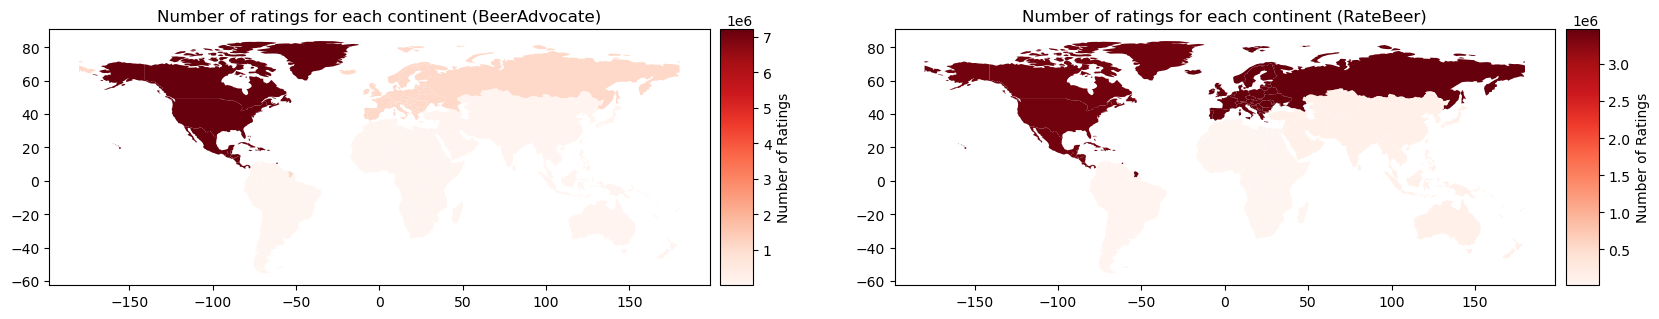

In [10]:
ba_nbr_ratings_per_continent = ba_beer_brewery.groupby('continent')['nbr_ratings'].sum()
rb_nbr_ratings_per_continent = rb_beer_brewery.groupby('continent')['nbr_ratings'].sum()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Map for BeerAdvocate
world_ba = world.merge(ba_nbr_ratings_per_continent, how='left', left_on='continent', right_index=True)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
world_ba.plot(column='nbr_ratings', ax=ax1, legend=True, cax=cax1, cmap='Reds', legend_kwds={'label': "Number of Ratings"})
ax1.set_title('Number of ratings for each continent (BeerAdvocate)')

# Map for RateBeer
world_rb = world.merge(rb_nbr_ratings_per_continent, how='left', left_on='continent', right_index=True)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
world_rb.plot(column='nbr_ratings', ax=ax2, legend=True, cax=cax2, cmap='Reds', legend_kwds={'label': "Number of Ratings"})
ax2.set_title('Number of ratings for each continent (RateBeer)')

plt.show()

Most ratings come from North America and Europe. Now we will have a closer look at the countries themselves. Notice that we don't have the same scale on the 2 maps.

### Number of ratings per country 

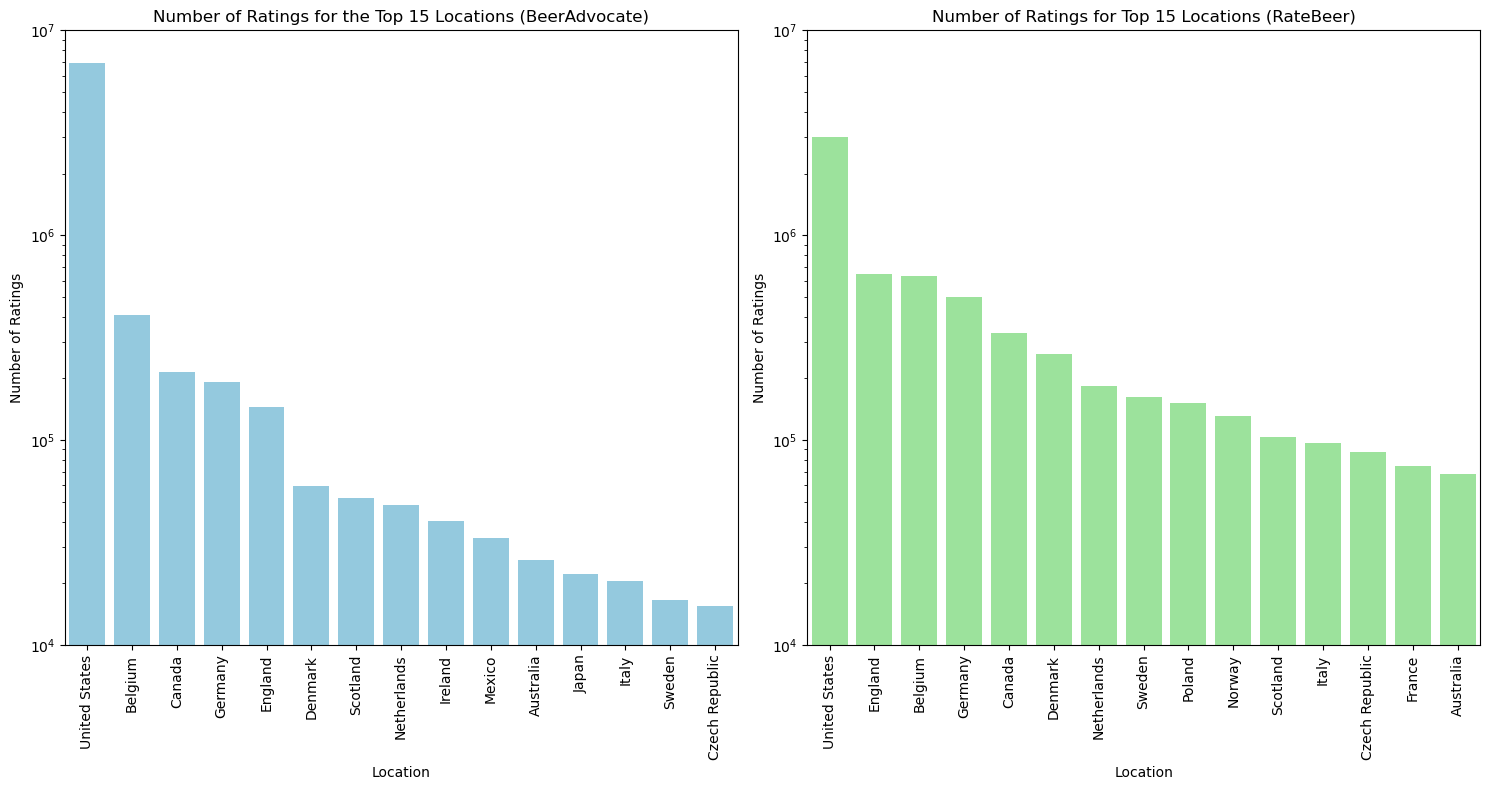

In [11]:
# Create a new column where all the states of the US are reunited 
ba_beer_brewery['countries'] = ba_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
rb_beer_brewery['countries'] = rb_beer_brewery['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

# Top 15 locations with the highest number of ratings
ba_highest_rated_per_location_top15 = ba_beer_brewery.groupby('countries')['nbr_ratings'].sum().nlargest(15)
rb_highest_rated_per_location_top15 = rb_beer_brewery.groupby('countries')['nbr_ratings'].sum().nlargest(15)

plt.figure(figsize=(15, 8)) 

# Plot for BeerAdvocate 
plt.subplot(1,2,1)
ax = sns.barplot(x=ba_highest_rated_per_location_top15.index, y=ba_highest_rated_per_location_top15.values, color='skyblue')
plt.title('Number of Ratings for the Top 15 Locations (BeerAdvocate)')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.ylim(10000, 10000000)
plt.xticks(rotation=90)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.barplot(x=rb_highest_rated_per_location_top15.index, y=rb_highest_rated_per_location_top15.values, color='lightgreen')
plt.title('Number of Ratings for Top 15 Locations (RateBeer)')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.ylim(10000, 10000000)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show() 

As we can see the number of ratings is not equal between each countries. One may think that a country with a lot of ratings might influence others. More specifically, the United States have a lot of ratings. However, normalizing by the population of each country might be more accurate and show us better the weight a country can have on the number of ratings. Then the idea would be to select these countries and see what styles are the most rated. 
In order to analyse the IPA trend we would look at which countries have been rating IPAs the most. 

Moreover, we can observe that the numer of ratings of the United States is quite high compared to other countries. Thus, taking a closer look at the ratings per states might be useful to analyse the trend.

### Number of ratings per US states

/var/folders/kb/n6_bdsmd2dsb51sjq7q00_jm0000gn/T/ipykernel_21791/2855485956.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ba_beer_brewery_US = ba_beer_brewery_US[~http_ref_ba]


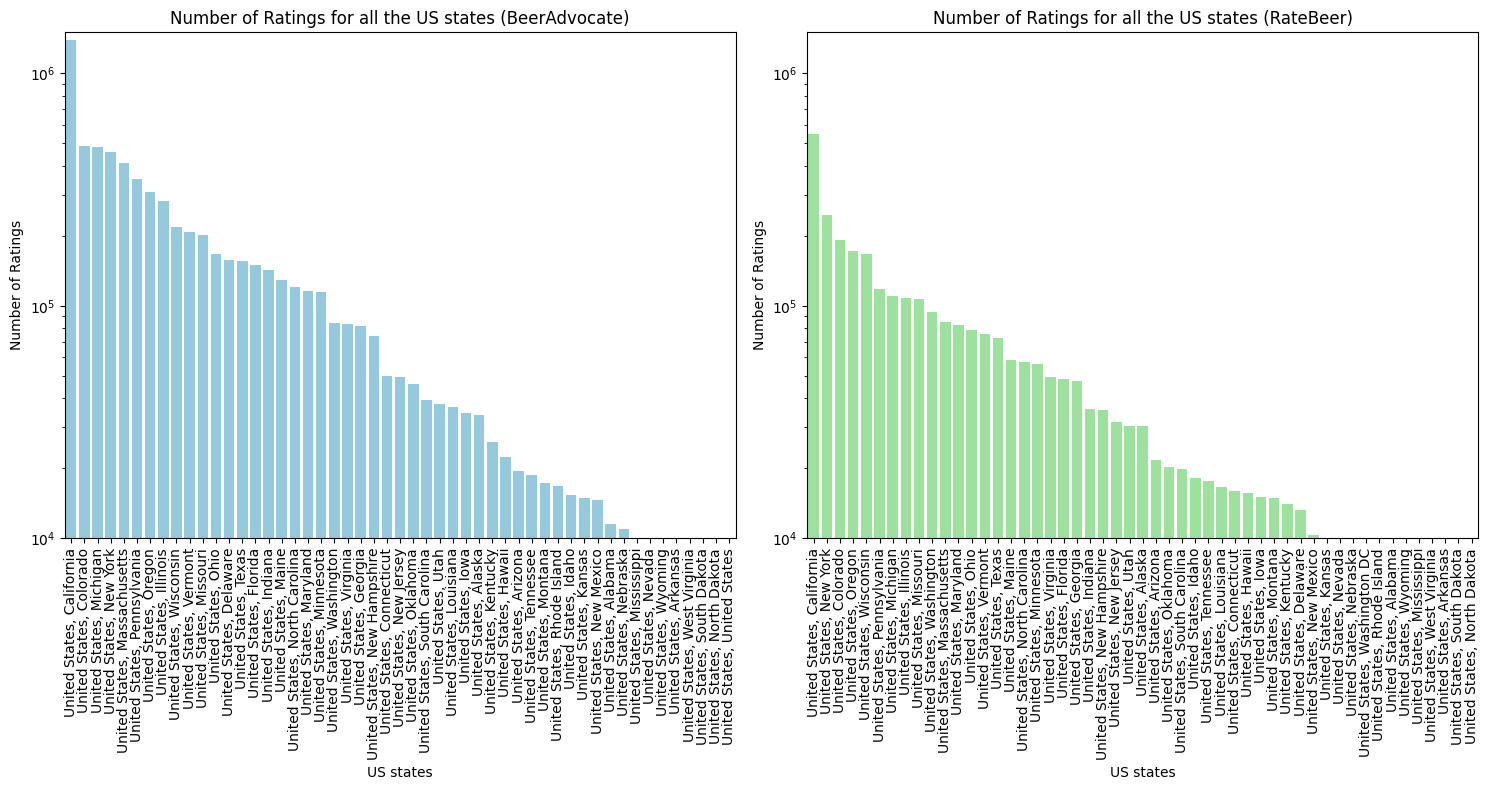

In [12]:
ba_beer_brewery_US = ba_beer_brewery.copy(deep=True)
rb_beer_brewery_US = rb_beer_brewery.copy(deep=True)

# Only keep the rows that are from the United States 
ba_beer_brewery_US = ba_beer_brewery[ba_beer_brewery['countries'] == 'United States']
rb_beer_brewery_US = rb_beer_brewery[rb_beer_brewery['countries'] == 'United States']

# Get rid of the states that aren't in the right format 
http_mask_ba = ba_beer_brewery_US['location'].str.contains('http')
http_ref_ba = ba_beer_brewery_US['location'].str.contains('href')
http_mask_rb = rb_beer_brewery_US['location'].str.contains('http')
http_ref_rb = rb_beer_brewery_US['location'].str.contains('href')

# Keep rows where 'location' does not contain "http" or "href"
ba_beer_brewery_US = ba_beer_brewery_US[~http_mask_ba]
ba_beer_brewery_US = ba_beer_brewery_US[~http_ref_ba]
rb_beer_brewery_US = rb_beer_brewery_US[~http_mask_rb]
rb_beer_brewery_US = rb_beer_brewery_US[~http_ref_rb]

ba_highest_rated_states = ba_beer_brewery_US.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False)
rb_highest_rated_states = rb_beer_brewery_US.groupby('location')['nbr_ratings'].sum().sort_values(ascending=False)

plt.figure(figsize=(15, 8)) 

# Plot for BeerAdvocate 
plt.subplot(1,2,1)
ax1 = sns.barplot(x=ba_highest_rated_states.index, y=ba_highest_rated_states.values, color='skyblue')
plt.title('Number of Ratings for all the US states (BeerAdvocate)')
plt.xlabel('US states')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(10000, 1500000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.barplot(x=rb_highest_rated_states.index, y=rb_highest_rated_states.values, color='lightgreen')
plt.title('Number of Ratings for all the US states (RateBeer)')
plt.xlabel('US states')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(10000, 1500000)

plt.tight_layout()
plt.show() 

There is a significant difference for the number of ratings between the states. This is helpful to analyse the pattern of the trend within the US giving us an even closer look at the trend. 

### Breweries 
Studying variables such as the number of breweries and the diversity of brewed beers could show if the trend came from microbreweries or on the countrary from big breweries. 

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/2475312092.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10000)
/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/2475312092.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10000)


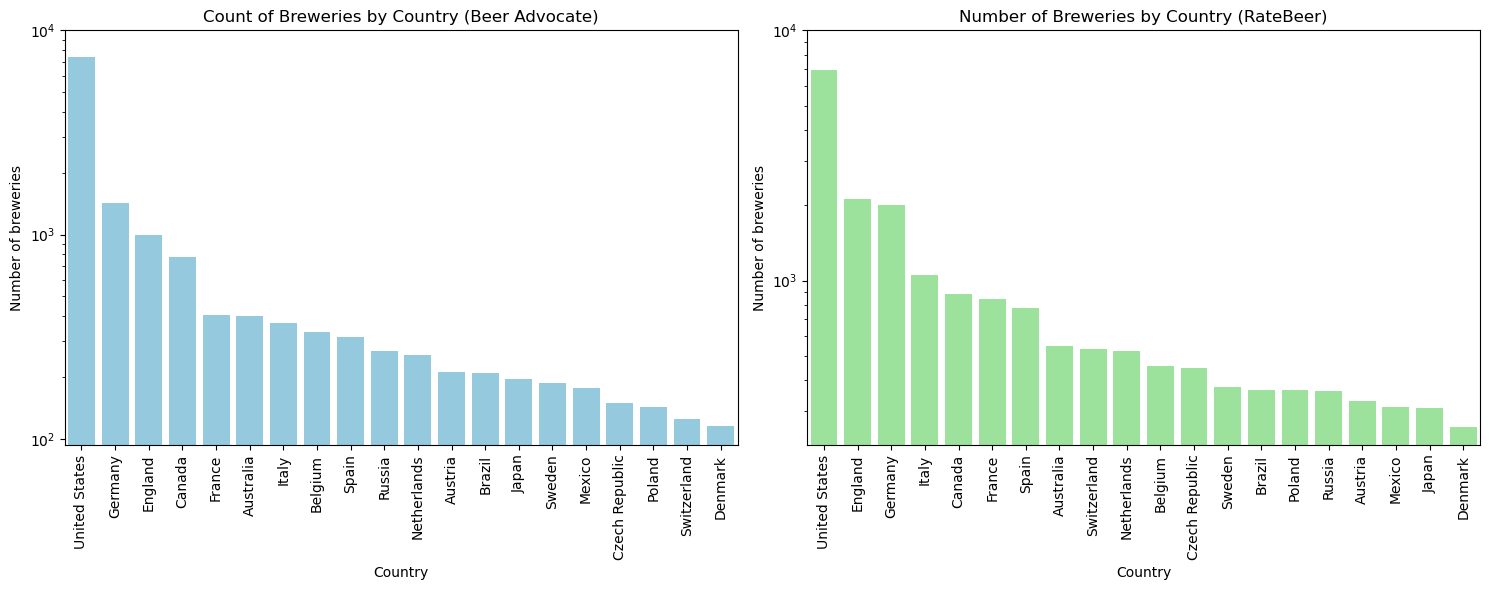

In [42]:
breweries_ba_f['countries'] = breweries_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 
                                                                 'United States' in x else x)
breweries_rb_f['countries'] = breweries_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 
                                                                 'United States' in x else x)

# Top 15 countries with the most breweries on RateBeer
nbr_breweries_rb = breweries_rb_f['countries'].value_counts().nlargest(20)
nbr_breweries_ba = breweries_ba_f['countries'].value_counts().nlargest(20)

# Plot for BeerAdvocate 
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=breweries_ba_f, x='countries', order=nbr_breweries_ba.index, color='skyblue')
plt.title('Count of Breweries by Country (Beer Advocate)')
plt.xlabel('Country')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,10000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.countplot(data=breweries_rb_f, x='countries', order=nbr_breweries_rb.index, color='lightgreen')
plt.title('Number of Breweries by Country (RateBeer)')
plt.xlabel('Country')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,10000)

plt.tight_layout()
plt.show()

Germany and England are definitely up there regarding the number of breweries. However, we can see that the United States are the country with the highest number of breweries. 

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/755601258.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000000)
/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/755601258.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000000)


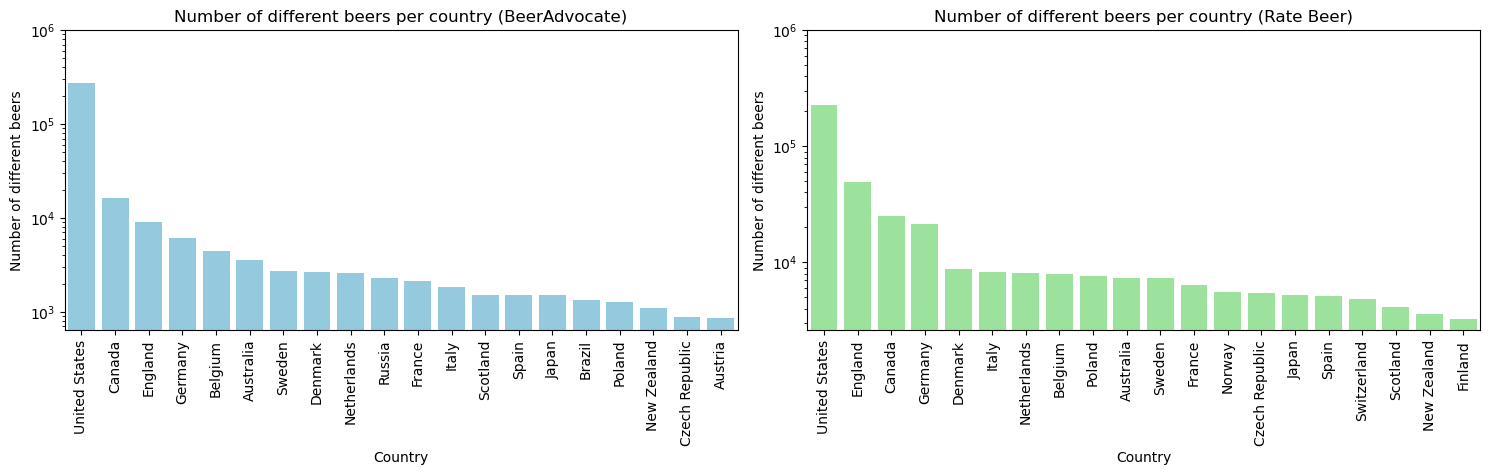

In [43]:
# Number of different beers per location 
rb_nbr_beer_location = breweries_rb_f.groupby('countries')['nbr_beers'].sum().nlargest(20)
ba_nbr_beer_location = breweries_ba_f.groupby('countries')['nbr_beers'].sum().nlargest(20)

plt.figure(figsize=(15, 8))  

plt.subplot(2,2,1)
ax1 = sns.barplot(x=ba_nbr_beer_location.index, y=ba_nbr_beer_location.values, color='skyblue')
plt.title('Number of different beers per country (BeerAdvocate)')
plt.xlabel('Country')
plt.ylabel('Number of different beers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0, 1000000)

plt.subplot(2,2,2)
ax2 = sns.barplot(x=rb_nbr_beer_location.index, y=rb_nbr_beer_location.values, color='lightgreen')
plt.title('Number of different beers per country (Rate Beer)')
plt.xlabel('Country')
plt.ylabel('Number of different beers')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0, 1000000)

plt.tight_layout()
plt.show()

The United States is the country that has the highest number of different brewed beers. However, we can see that even for smaller countries such as Germany and England they are still in the top 5. For further analysis we could study the weight that each country has in the diversity of beers. Then we will be able to analyse the production of each style of beer for every country. More specifically we could see the country which produces the highest number of IPAs. 
Furthermore, we could normalize the number of beers by the population of each country and see which country produces the highest number of IPAs per habitants. This could help us identify countries where IPAs is trendy. 

# 4. Social analysis of the trend 

We will now focus on the type of users that rate the beers on the websites. Regarding the users we will look at their origin, the date in which they entered the websites, and the styles of beer they review. One important factor of a trend is the time so will mostly study these in a chronological way.  
One goal here would be to identify fan clubs which could be another metric to identify the trend of IPAs

### Number of users per country

/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/3535490044.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000000)
/var/folders/ww/2h7smtxn681_s7wdrgv_mxc40000gn/T/ipykernel_788/3535490044.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000000)


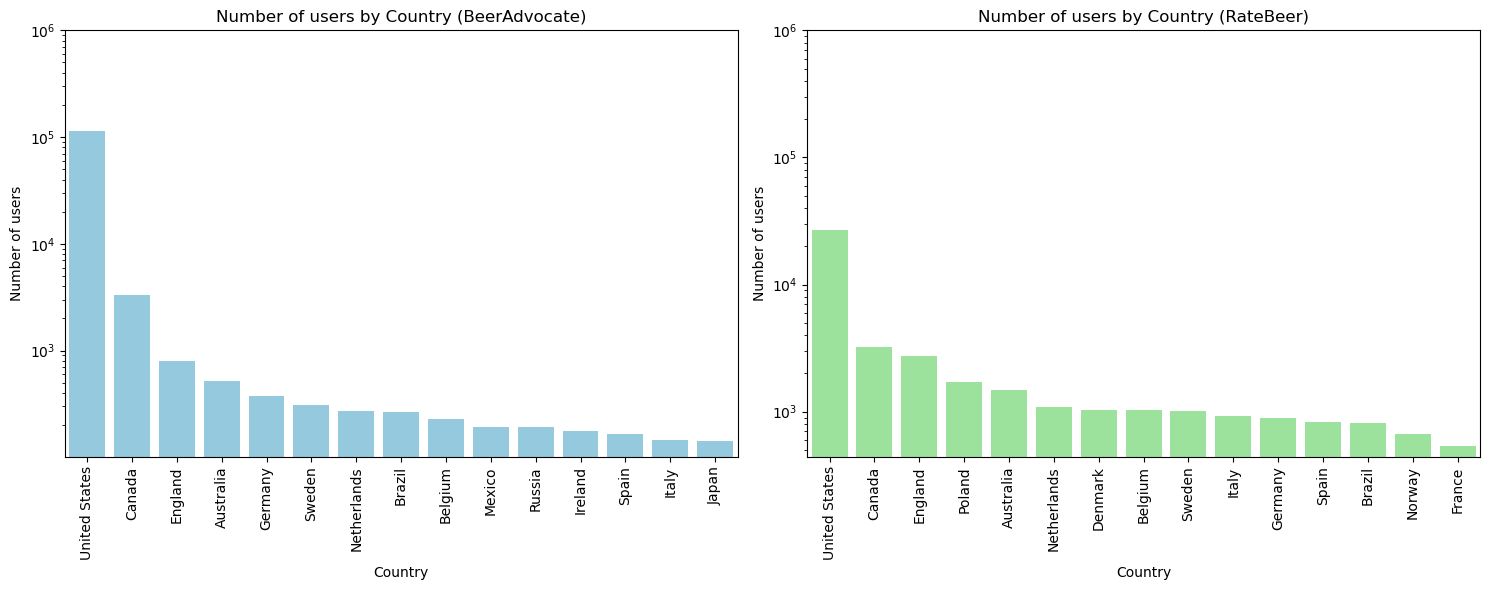

In [44]:
users_ba_f['location'] = users_ba_f['location'].dropna()
users_rb_f['location'] = users_rb_f['location'].dropna()

# Group variations of 'United States' in the 'country' column
users_ba_f['countries'] = users_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)
users_rb_f['countries'] = users_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

# Get the 15 most represented countries
nbr_users_ba = users_ba_f['countries'].value_counts().nlargest(15)
nbr_users_rb = users_rb_f['countries'].value_counts().nlargest(15)

# Plot for BeerAdvocate 
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=users_ba_f, x='countries', order=nbr_users_ba.index, color='skyblue')
plt.title('Number of users by Country (BeerAdvocate)')
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,1000000)

# Plot for RateBeer
plt.subplot(1,2,2)
ax2 = sns.countplot(data=users_rb_f, x='countries', order=nbr_users_rb.index, color='lightgreen')
plt.title('Number of users by Country (RateBeer)')
plt.xlabel('Country')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(0,1000000)

plt.tight_layout()
plt.show()

Most of the users are americans.

### Ratings from BeerAdvocate & RateBeer

Why Ratings instead of Reviews? Simply because Reviews is a subset of Ratings. So by analyzing the former, we analyze the latter.

### BeerAdvocate

In [45]:
# Start by loading reviews.csv from BeerAdvocate
#ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')
ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')

users_ba_f = users_ba.copy(deep=True)

# Load reviews.csv from RateBeer
#ratings_rb_f = pd.read_csv(f'{path_rb}/ratings.csv')
ratings_rb_f = pd.read_csv(f'{path_rb}/ratings.csv')

users_rb_f= users_rb.copy(deep=True)

In [46]:
# Merge users from BeerAdvocate in rating file with their countries info

ratings_ba_f = ratings_ba_f.merge(users_ba_f, on='user_name', how='left')
ratings_ba_f['location'] = ratings_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

ratings_ba_f['date'] = convert_to_date(ratings_ba_f['date'])
ratings_ba_f['joined'] = convert_to_date(ratings_ba_f['joined'])


# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ratings_ba_f['date'] = pd.to_datetime(ratings_ba_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
ratings_ba_f['joined'] = pd.to_datetime(ratings_ba_f['joined'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [47]:
ratings_ba_f.isna().sum()

beer_name             0
beer_id               0
brewery_name          0
brewery_id            0
style                 0
abv              171305
date                  0
user_name            31
user_id_x             0
appearance      3623357
aroma           3623357
palate          3623357
taste           3623357
overall         3623357
rating                0
text            5677323
review                0
nbr_ratings           0
nbr_reviews           0
user_id_y             0
joined           347909
location         500278
dtype: int64

We identify more than 5,677,323 lines without comments. This is due to the use of BeerAdvocate ratings.csv, as the site does not require the user to submit a text with the ratings. We also have a large number of Nan for the different notes (appareance, arome, palate,...). Let's see if it's always the same users who tend to omit information.

In [48]:
# Delete duplicate users
ratings_ba_f.drop_duplicates(subset='user_name').isna().sum()

beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
abv              1601
date                0
user_name           1
user_id_x           0
appearance      71136
aroma           71136
palate          71136
taste           71136
overall         71136
rating              0
text            98502
review              0
nbr_ratings         0
nbr_reviews         0
user_id_y           0
joined           2652
location        31279
dtype: int64

We note the presence of 2,652 users whose date of joining BeerAdvocate is unknown. And 31,279 out of 153,705 did not specify their location. We can also see that the same users tend not to fill in all the data (abv, text, appearance, aroma, palate, taste, overall) as the number of Nan decreases when usernames duplicates are removed (this means we keep only one comment per user). 

We may have to remove these users, who provide little information.

### RateBeer

In [49]:
# Merge users from RateBeer in ratings file with their countries info

ratings_rb_f = ratings_rb_f.merge(users_rb_f, on='user_name', how='left')
ratings_rb_f['location'] = ratings_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)


ratings_rb_f['date'] = convert_to_date(ratings_rb_f['date'])
ratings_rb_f['joined'] = convert_to_date(ratings_rb_f['joined'])


# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
ratings_rb_f['date'] = pd.to_datetime(ratings_rb_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')
ratings_rb_f['joined'] = pd.to_datetime(ratings_rb_f['joined'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

In [50]:
ratings_rb_f.isna().sum()

beer_name            0
beer_id              0
brewery_name         0
brewery_id           0
style                0
abv             174984
date                 0
user_name            0
user_id_x            0
appearance           0
aroma                0
palate               0
taste                0
overall              0
rating               0
text               448
nbr_ratings          0
user_id_y            0
joined            2627
location        203679
dtype: int64

We have no missing values, except for the alcohol content of the beer and the text, but the latter is very low and the degree of alcohol is of no interest to us in our study.
To study nbr_ratings, joined and location we need to remove duplicates. 

In [51]:
# Delete duplicate users to get other statistics 
ratings_rb_f.drop_duplicates(subset='user_name').isna().sum()

beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
abv               974
date                0
user_name           0
user_id_x           0
appearance          0
aroma               0
palate              0
taste               0
overall             0
rating              0
text               27
nbr_ratings         0
user_id_y           0
joined             30
location        19579
dtype: int64

19,579 users out of 70,175 did not specify their location. Even if this number is high, it may represent users who don't post regularly (below 3 comments, the median number of ratings per beer). This should not be a problem for the rest of our project.
For the account creation date, the number of missing values is minimal.

In [52]:
# Verify that it is the case 
ratings_rb_f[ratings_rb_f['nbr_ratings'] >= 3].drop_duplicates(subset='user_name').isna().sum()

beer_name          0
beer_id            0
brewery_name       0
brewery_id         0
style              0
abv              311
date               0
user_name          0
user_id_x          0
appearance         0
aroma              0
palate             0
taste              0
overall            0
rating             0
text              11
nbr_ratings        0
user_id_y          0
joined            18
location        7074
dtype: int64

We can see straight away that the number of users without a location has fallen sharply by selecting users with at least 3 reviews. 

### Score analysis

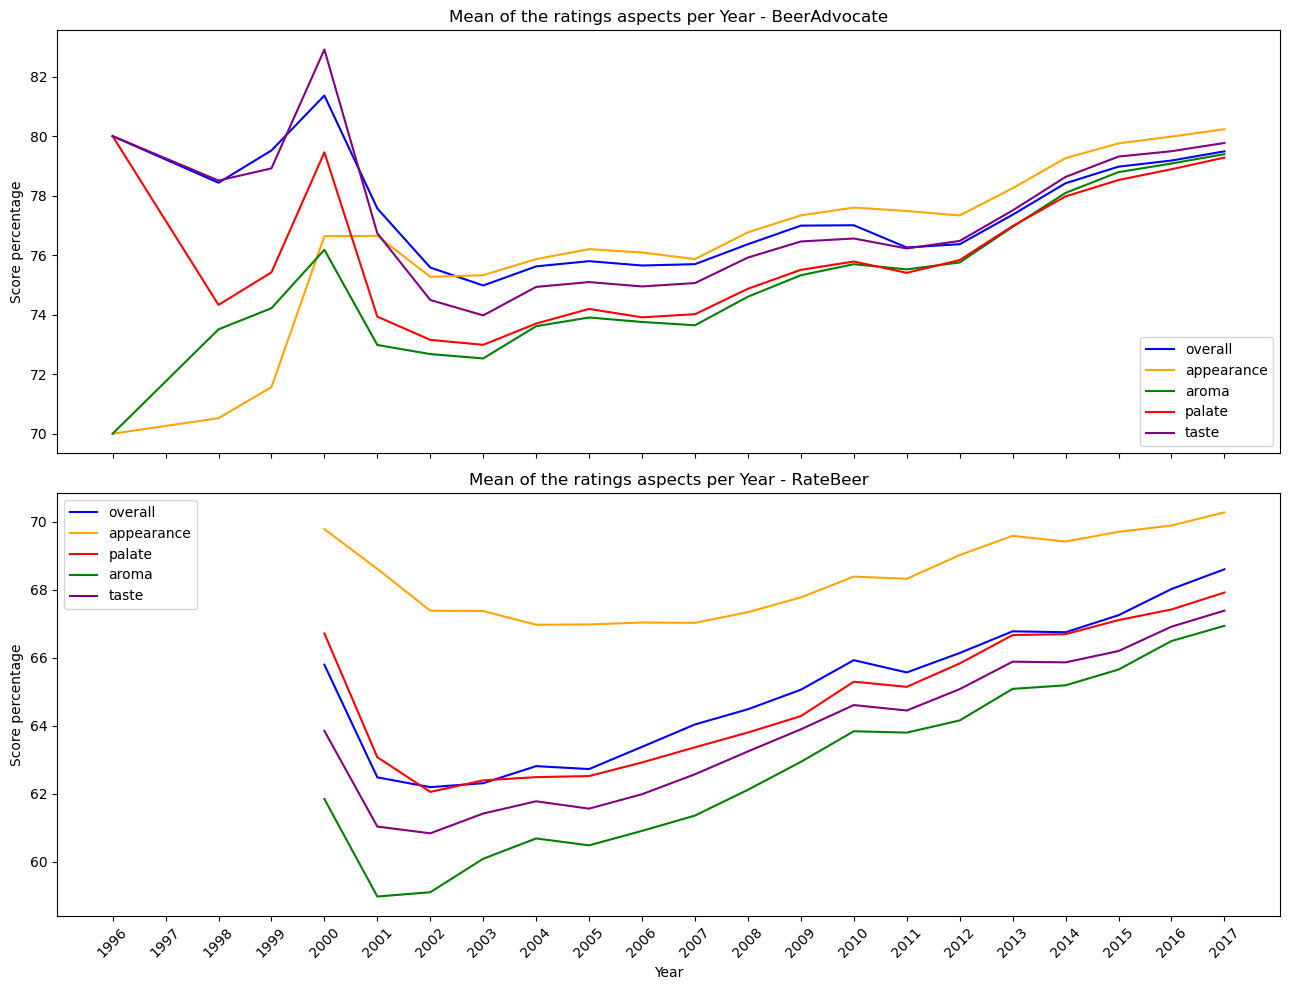

In [53]:
# Evolution of mean tastes along the years for RateBeer 
summary_df_rb = ratings_rb_f.groupby('date').agg({
    'overall': lambda x: (x.mean() / 20) * 100, ## Overwall is rated out of 20 
    'appearance': lambda x: (x.mean() / 5) * 100, ## Appearance is rated out of 5
    'aroma': lambda x: (x.mean() / 10) * 100, ## Taste is rated out of 10
    'palate': lambda x: (x.mean() / 5) * 100, ## Taste is rated out of 5
    'taste': lambda x: (x.mean() / 10) * 100 ## Taste is rated out of 5
}).reset_index()


# Evolution of mean tastes along the years for BeerAdvocate (Everything is rated out of 5)
summary_df_ba = ratings_ba_f.groupby('date').agg({
    'overall': lambda x: (x.mean() / 5) * 100,
    'appearance': lambda x: (x.mean() / 5) * 100,
    'aroma': lambda x: (x.mean() / 5) * 100,
    'palate': lambda x: (x.mean() / 5) * 100,
    'taste': lambda x: (x.mean() / 5) * 100
}).reset_index()

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

# Plot for BeerAdvocate
axs[0].plot(summary_df_ba['date'], summary_df_ba['overall'], label='overall',color='blue')
axs[0].plot(summary_df_ba['date'], summary_df_ba['appearance'], label='appearance',color='orange')
axs[0].plot(summary_df_ba['date'], summary_df_ba['aroma'], label='aroma',color='green')
axs[0].plot(summary_df_ba['date'], summary_df_ba['palate'], label='palate',color='red')
axs[0].plot(summary_df_ba['date'], summary_df_ba['taste'], label='taste',color='purple')
axs[0].set_ylabel('Score percentage')
axs[0].set_title('Mean of the ratings aspects per Year - BeerAdvocate')
axs[0].legend()

# Plot for RateBeer
axs[1].plot(summary_df_rb['date'], summary_df_rb['overall'], label='overall',color='blue')
axs[1].plot(summary_df_rb['date'], summary_df_rb['appearance'], label='appearance',color='orange')
axs[1].plot(summary_df_rb['date'], summary_df_rb['palate'], label='palate',color='red')
axs[1].plot(summary_df_rb['date'], summary_df_rb['aroma'], label='aroma',color='green')
axs[1].plot(summary_df_rb['date'], summary_df_rb['taste'], label='taste',color='purple')
axs[1].set_ylabel('Score percentage')
axs[1].set_xlabel('Year')
axs[1].set_title('Mean of the ratings aspects per Year - RateBeer')
axs[1].set_xticks(np.arange(1996, 2018, step=1))
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

It can be seen that, on average, scores tend to increase on both sites. We have comments from 1996 users on BeerAdvocate. Let's see how many there are:

### Number of comments per years for both datasets:

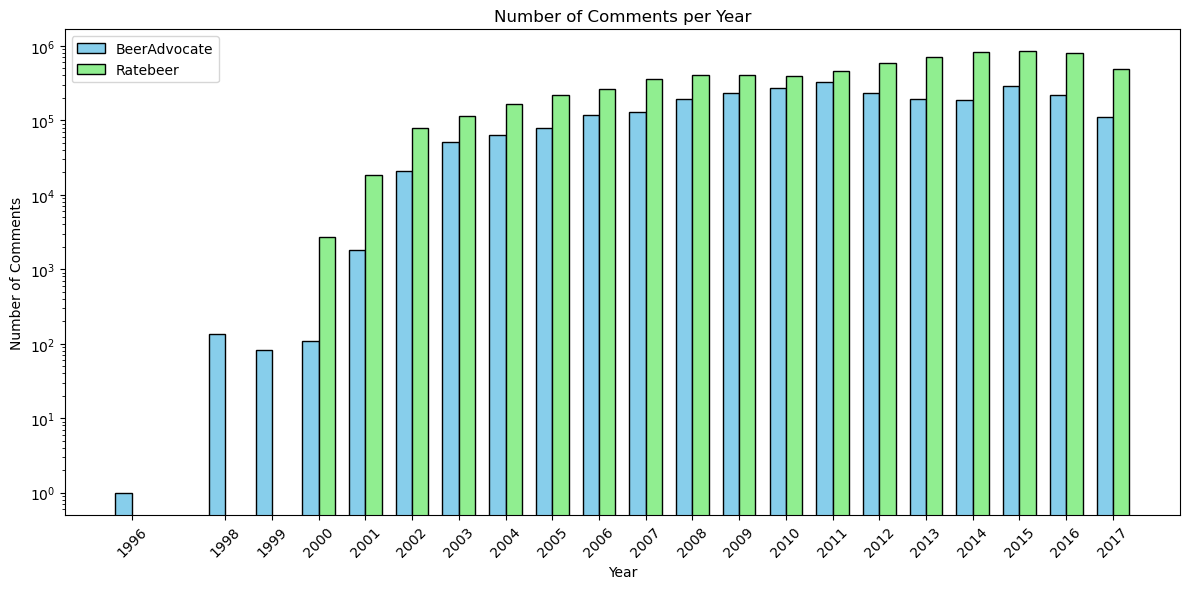

In [54]:
# For BeerAdvocate
comments_per_year_ba = ratings_ba_f.groupby('date')["text"].count().reset_index()
comments_per_year_ba.columns = ['Year', 'nb of comments']

# For Ratebeer
comments_per_year_rb = ratings_rb_f.groupby('date')["text"].count().reset_index()
comments_per_year_rb.columns = ['Year', 'nb of comments']

# Add values from 1996 to 1999
missing_years = pd.DataFrame({'Year': [1996, 1998, 1999], 'nb of comments': [0, 0, 0]})
comments_per_year_rb = pd.concat([missing_years, comments_per_year_rb]).sort_values('Year')

years = np.array([year for year in range(1996, 2018) if year != 1997])

bar_width = 0.35  # Largeur des barres

plt.figure(figsize=(12, 6))

plt.bar(years - bar_width/2, comments_per_year_ba['nb of comments'], bar_width, color='skyblue', label='BeerAdvocate', edgecolor='black')
plt.bar(years + bar_width/2, comments_per_year_rb['nb of comments'], bar_width, color='lightgreen', label='Ratebeer', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.yscale('log')
plt.title('Number of Comments per Year')
plt.xticks(years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

There was only one comment in 1996 and 0 in 1997. With further verification (not detailed here) we were able to see that it was the founder of BeerAdvocate (Todd Alström) who wrote this comment in 1996.

In any case, what we can see here is that to try and identify a trend in beer consumption, we can't base ourselves on years too close to creation. Instead, look for years when the number of comments has exceeded 10^4. So around 2002. 

### Number of new users per years for both datasets:

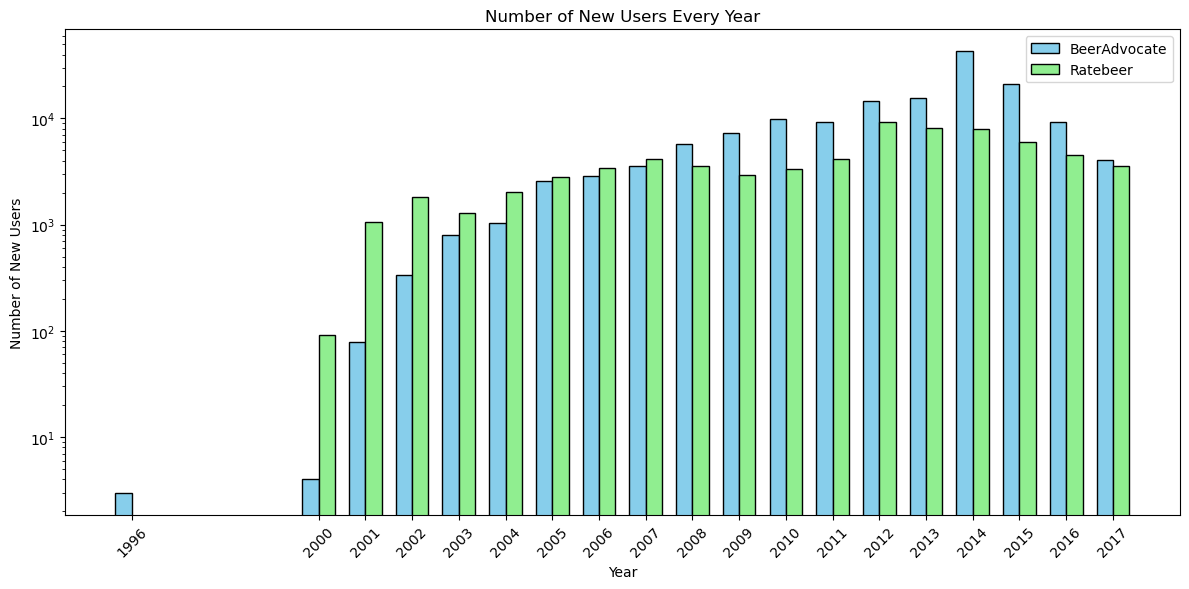

In [55]:
# New users computation for RateBeer
new_users_per_year_rb = ratings_rb_f.groupby('joined')['user_id_y'].nunique().reset_index()

# New users computation for BeerAdvocate
new_users_per_year_ba = ratings_ba_f.groupby('joined')['user_id_y'].nunique().reset_index()

# Add values for 1996
missing_years = pd.DataFrame({'joined': [1996], 'nb of user_id_y': [0]})
new_users_per_year_rb = pd.concat([missing_years, new_users_per_year_rb]).sort_values('joined')

years = np.array([year for year in range(1996, 2018) if year not in [1997, 1998, 1999]])

bar_width = 0.35  # Width of bar 

plt.figure(figsize=(12, 6))

plt.bar(years - bar_width/2, new_users_per_year_ba['user_id_y'], bar_width, color='skyblue', label='BeerAdvocate', edgecolor='black')
plt.bar(years + bar_width/2, new_users_per_year_rb['user_id_y'], bar_width, color='lightgreen', label='Ratebeer', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of New Users')
plt.title('Number of New Users Every Year')
plt.xticks(years, rotation=45)
plt.yscale('log')
plt.legend()
plt.tight_layout()

One interesting thing can be identified from these two barplots: although BeerAdvocate seems to attract more new users every year than RateBeer, there are more comments per year on the latter. The reason for this is that RateBeer requires its users to comment on the beers.

In any case, the number of new users seems to correlate with the number of comments per year.

### Exploring grades

We can look at the rating column, which is the weighted average of 'palate', 'taste', 'aroma', 'appearance' and 'overall'. But since the rating scales are different (RateBeer uses different scales, e.g. between appearance and taste, as we saw earlier), it's best to standardize them for proper analysis. 

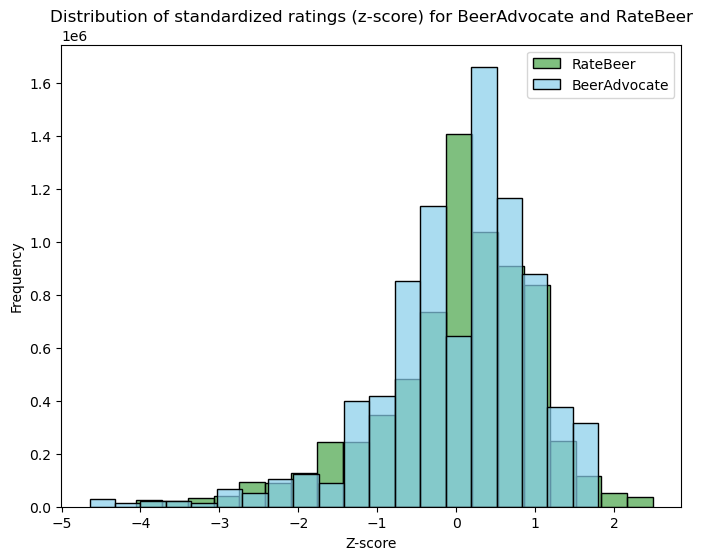

KeyboardInterrupt: 

In [ ]:
# Apply a Z-score for 'ratings' in RateBeer ratings
ratings_zscore_rb = (ratings_rb_f['rating'] - ratings_rb_f['rating'].mean()) / ratings_rb_f['rating'].std()

# Apply a Z-score for 'ratings' in BeerAdvocate ratings
ratings_zscore_ba = (ratings_ba_f['rating'] - ratings_ba_f['rating'].mean()) / ratings_ba_f['rating'].std()

plt.figure(figsize=(8, 6))

sns.histplot(ratings_zscore_rb, bins=20, color='green', alpha=0.5, label='RateBeer')
sns.histplot(ratings_zscore_ba, bins=20, color='skyblue', alpha=0.7, label='BeerAdvocate')

plt.title('Distribution of standardized ratings (z-score) for BeerAdvocate and RateBeer')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In general, we can see that the ratings for RateBeer and BeerAdvocate are quite similar, but RateBeer has more high ratings.

# 5. Language processing

### For BeerAdvocate 

In [ ]:
# Chunk size
chunk_size = 1000

# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text
    
# Create a Reader object to read the CSV file in chunks
csv_reader = pd.read_csv(f"{path_ba}/reviews.csv", chunksize=chunk_size, encoding='utf-8')

# Iterate through all chunks
for chunk in csv_reader:
    # Initialize a list to store language vectors for the current chunk
    chunk_lang_vectors = []
    
    for index, row in chunk.iterrows():
        try:
            # Apply the language detection function to the text column
            # Unknown if NAN
            lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

        except Exception as e:
            # Clean the text only for the row that caused an error
            cleaned_text = clean_text(str(row['text']))
            # Reapply language detection after cleaning
            lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

    # Concatenate the language vectors for the current chunk
    chunk_lang_series = pd.Series(chunk_lang_vectors, name='lang')
    lang_vectors.append(chunk_lang_series)

# Concatenate all language vectors into a single vector
result_lang_vector = pd.concat(lang_vectors, ignore_index=True)

# Display
print(result_lang_vector.unique())

NameError: name 'cld2' is not defined

In [ ]:
# Plot percentage

# Calculate the counts of each language
lang_counts = result_lang_vector.value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color="skyblue", logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.show()

print(f"Percentage of unrecognized language: {lang_percentages.get('Unknown', 0):.4f}%")
print(f"Percentage of empty comments: {lang_percentages.get('NaN', 0):.5f}%")


Unsurprisingly, over 99% of comments are written in English, 0.0014% of comments are in a language not recognized by cld2 and a very small number are empty.
We can have a quick look at the distribution of languages if we remove users from USA knowing (from the previous analysis) that they are the most numerous users of this site.

In [ ]:
# Start by loading reviews.csv from BeerAdvocate
reviews_ba_f = pd.read_csv(f'{path_ba}/reviews.csv', usecols=['user_name','text'])

# Use column user_name and location only
users_ba_f= users_ba[["user_name","location"]].copy(deep=True)

# Remove states info, keep only Country
users_ba_f['location'] = users_ba_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [ ]:
# Merge on User_name and remove United States
reviews_ba_f = reviews_ba_f.merge(users_ba_f, on='user_name', how='left')
reviews_ba_f = reviews_ba_f[reviews_ba_f['location'] != 'United States']

In [ ]:
# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Iterate through all rows in the DataFrame
for index, row in reviews_ba_f.iterrows():
    try:
        # Apply the language detection function to the text column
        # Unknown if NaN
        lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

    except Exception as e:
        # Clean the text only for the row that caused an error
        cleaned_text = clean_text(str(row['text']))
        # Reapply language detection after cleaning
        lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

# Create a new column 'lang' in the reviews_ba_f DataFrame
reviews_ba_f['lang'] = lang_vectors

# Display the unique languages detected
print(reviews_ba_f['lang'].unique())

In [ ]:
# Calculate the counts of each language
lang_counts = reviews_ba_f['lang'].value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color="skyblue", logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate excluding US users')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.plot()

Surprisingly (or not), even if you remove users from the USA, the most widely spoken language is still English.

### For RateBeer

In [ ]:
# Chunk size
chunk_size = 1000

# Initialize a list to store language vectors
lang_vectors_rb = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Create a Reader object to read the CSV file in chunks
csv_reader = pd.read_csv(f"{path_rb}/reviews.csv", chunksize=chunk_size, encoding='utf-8')

# Iterate through all chunks
for chunk in csv_reader:
    # Initialize a list to store language vectors for the current chunk
    chunk_lang_vectors = []
    
    for index, row in chunk.iterrows():
        try:
            # Apply the language detection function to the text column
            # Unknown if NAN
            lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

        except Exception as e:
            # Clean the text only for the row that caused an error
            cleaned_text = clean_text(str(row['text']))
            # Reapply language detection after cleaning
            lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
            # Add the language to the list
            chunk_lang_vectors.append(lang)

    # Concatenate the language vectors for the current chunk
    chunk_lang_series = pd.Series(chunk_lang_vectors, name='lang')
    lang_vectors_rb.append(chunk_lang_series)

# Concatenate all language vectors into a single vector
result_lang_vector_rb = pd.concat(lang_vectors_rb, ignore_index=True)

# Display the result
print(result_lang_vector_rb.unique())

In [ ]:
# Plot ratio

# Calculate the counts of each language
lang_counts_rb = result_lang_vector_rb.value_counts()

# Calculate the ratio of each language
lang_percentages_rb = lang_counts_rb / lang_counts_rb.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages_rb.plot(kind='bar', color="lightgreen",logy=True)
plt.title('Language Distribution in reviews from Ratebeer')
plt.xlabel('Language')
plt.ylabel('Percentage')

plt.show()

print(f"Percentage of unrecognized language: {lang_percentages_rb.get('Unknown', 0):.4f}%")
print(f"Percentage of empty comments: {lang_percentages_rb.get('NaN', 0):.4f}%")

Once again, English is by far the dominant language. However, there are many more languages than in BeerAdvocate.
There are also more empty comments and unrecognized languages. This is due to the number of comments, as RateBeer's dataset contains 7 122 074 comments compared to the 2 589 586 comments in BeerAdvocate's dataset.

As before, let's look at the distribution of languages without users living in the USA. 

In [ ]:
# Start by loading reviews.csv from RateBeer
reviews_rb_f = pd.read_csv(f'{path_rb}/reviews.csv', usecols=['user_name','text'])

users_rb_f= users_rb[["user_name","location"]].copy(deep=True)
users_rb_f['location'] = users_rb_f['location'].apply(lambda x: 'United States' if isinstance(x, str) and 'United States' in x else x)

In [ ]:
# Merge on User_name and remove United States
reviews_rb_f = reviews_rb_f.merge(users_rb_f, on='user_name', how='left')
reviews_rb_f = reviews_rb_f[reviews_rb_f['location'] != 'United States']

In [ ]:
# Initialize a list to store language vectors
lang_vectors = []

def clean_text(text):
    # Omit non-UTF-8 characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c) != 'Cc' or c == '\n')
    return cleaned_text

# Iterate through all rows in the DataFrame
for index, row in reviews_rb_f.iterrows():
    try:
        # Apply the language detection function to the text column
        # Unknown if NaN
        lang = cld2.detect(str(row['text']))[2][0][0] if pd.notna(row['text']) and cld2.detect(str(row['text']))[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

    except Exception as e:
        # Clean the text only for the row that caused an error
        cleaned_text = clean_text(str(row['text']))
        # Reapply language detection after cleaning
        lang = cld2.detect(cleaned_text)[2][0][0] if cld2.detect(cleaned_text)[2] else 'NaN'
        # Add the language to the list
        lang_vectors.append(lang)

# Create a new column 'lang' in the reviews_ba_f DataFrame
reviews_rb_f['lang'] = lang_vectors

# Display the unique languages detected
print(reviews_rb_f['lang'].unique())

In [ ]:
# Calculate the counts of each language
lang_counts = reviews_rb_f['lang'].value_counts()

# Calculate the percentage of each language
lang_percentages = lang_counts / lang_counts.sum() * 100

# Plotting
plt.figure(figsize=(15, 6))
ax = lang_percentages.plot(kind='bar', color="lightgreen", logy=True)
plt.title('Language Distribution in reviews from BeerAdvocate excluding US users')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.plot()

Considering the language analysis of both websites we will only keep the reviews that are written in english.

# Project Milestone P3:

## Statistical test on the grades:

In [47]:
# Anova test for BeerAdvocate 
styles = ratings_ba_f['style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_ba_f['rating'][ratings_ba_f['style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 27524.401150653128
P-value: 0.0


In [ ]:
# Anova test for RateBeer
styles = ratings_rb_f['style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_rb_f['rating'][ratings_rb_f['style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 42614.13844927083
P-value: 0.0


In [ ]:
# Anova test for bigger categories of BeerAdvocate 
# For each category find the broader style associated to the beer style
ratings_ba_f['bigger_style'] = ratings_ba_f['style'].apply(categorize_style)
styles = ratings_ba_f['bigger_style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_ba_f['rating'][ratings_ba_f['bigger_style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 112814.6357193032
P-value: 0.0


In [ ]:
# Anova test for bigger categories of RateBeer 
# For each category find the broader style associated to the beer style
ratings_rb_f['bigger_style'] = ratings_rb_f['style'].apply(categorize_style)
styles = ratings_rb_f['bigger_style'].unique()
# Create a dict with scores associated to each styles
anova_data = {style: ratings_rb_f['rating'][ratings_rb_f['bigger_style'] == style] for style in styles}

f_statistic, p_value = f_oneway(*anova_data.values())

print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

F-statistic: 176844.39851397127
P-value: 0.0


Given than for every ANOVA tests we have p-value < 0.05, we know that there is at least one beer style that has a mean significantly different than other styles. To understand which styles have different mean, we will perform a posthoc analysis with tukey's hsd test (hhonest significance test). For the sake of simplicity, we will do this only on broader styles

In [ ]:
tukey_result_ba = pairwise_tukeyhsd(ratings_ba_f['rating'], ratings_ba_f['bigger_style'])
tukey_result_rb = pairwise_tukeyhsd(ratings_rb_f['rating'], ratings_rb_f['bigger_style'])

# Display the significant styles for each website
print("Tukey's HSD results for BeerAdvocate")
print(tukey_result_ba)

print("Tukey's HSD results for RateBeer")
print(tukey_result_rb)

Tukey's HSD results for BeerAdvocate
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------
          Bocks      Brown Ales  -0.0663   0.0 -0.0725   -0.06   True
          Bocks       Dark Ales   0.0219   0.0  0.0158   0.028   True
          Bocks     Dark Lagers  -0.2272   0.0 -0.2333 -0.2211   True
          Bocks    Hybrid Beers   -0.161   0.0 -0.1708 -0.1513   True
          Bocks India Pale Ales   0.1971   0.0   0.192  0.2021   True
          Bocks           Other   0.0589   0.0  0.0515  0.0662   True
          Bocks       Pale Ales   -0.036   0.0 -0.0411 -0.0309   True
          Bocks     Pale Lagers  -0.7022   0.0 -0.7078 -0.6967   True
          Bocks         Porters   0.1284   0.0  0.1225  0.1342   True
          Bocks Specialty Beers  -0.1606   0.0 -0.1662  -0.155   True
          Bocks          Stouts   0.2961   0.0  0.290

**PostHoc results:** We observe that the only pair for which we do not reject the null hypothesis that the mean are not different is the *Hybrid Beers - Specialty Beers* in the BeerAdvocate dataset. For every other pair, there is thus a significant difference in mean ratings. This may come as surprising, as from the histogram we plotted in [Ratings distribution](#Average-score-per-style) suggested that means of most styles were very close to each other. This is likely due to the effect size, because sample size are very large, even very small differences can become significant.

# Fanbase

### For beer advocate

In [12]:
ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')

In [13]:
ratings_ba_f = ratings_ba_f[['style','user_id','rating']]
ratings_ba_f['bigger_style'] = ratings_ba_f['style'].apply(categorize_style)

#Only keep users that posted 5 review or more (so we don't have "fans" that posted 2 reviews)
user_review_counts = ratings_ba_f['user_id'].value_counts()
valid_users = user_review_counts[user_review_counts >= 5].index
ratings_ba_f = ratings_ba_f[ratings_ba_f['user_id'].isin(valid_users)]

In [28]:
#Start by defining the percentage of review per beer style for each users
style_percentage = ratings_ba_f.groupby(['user_id', 'bigger_style'])['rating'].count() / ratings_ba_f.groupby('user_id')['rating'].count()

#Keep only user a have one of the percentages >.75 
fan_users = style_percentage[style_percentage >= 0.75].reset_index()
 
#Identify the preferred style
fan_users = fan_users.groupby('user_id')['bigger_style'].first().reset_index()

#Enrich with informations from the first dataset
fan_users = pd.merge(fan_users, ratings_ba_f, on=['user_id', 'bigger_style'], how='left')

#Reduce to one row per user, by computing the mean grade given to preferred style
fan_users = fan_users.groupby(['user_id', 'bigger_style'])['rating'].mean().reset_index()

#Enrich with the location by merging with user df
user_loc = users_ba[['user_id', 'location']]
fan_users_ba = pd.merge(fan_users, user_loc, on = ['user_id'], how = 'left')

fan_users_ba.columns = ['user_id', 'preferred_style', 'avg_rating','location']

In [31]:
#Now we extract statistics about the users:
print(fan_users_ba['preferred_style'].value_counts())
histo_fans = fan_users_ba['preferred_style'].value_counts()
style_avg_rating_by_fan = fan_users_ba.groupby('preferred_style')['avg_rating'].mean().reset_index()
style_avg_rating_by_fan['avg_rating'] = sorted(style_avg_rating_by_fan['avg_rating'],reverse= True)
fan_users_ba = fan_users_ba[fan_users_ba['preferred_style'] == 'India Pale Ales'].reset_index()
print(style_avg_rating_by_fan)

preferred_style
India Pale Ales    2819
Stouts              307
Pale Lagers         270
Strong Ales          98
Pale Ales            74
Wild/Sour Beers      72
Wheat Beers          69
Specialty Beers      61
Dark Lagers          13
Porters              10
Bocks                 5
Brown Ales            3
Dark Ales             2
Other                 2
Name: count, dtype: int64
    preferred_style  avg_rating
0             Bocks    4.400000
1        Brown Ales    4.334531
2         Dark Ales    4.328332
3       Dark Lagers    4.316443
4   India Pale Ales    4.312668
5             Other    4.269392
6         Pale Ales    4.110289
7       Pale Lagers    4.098333
8           Porters    4.045930
9   Specialty Beers    3.980431
10           Stouts    3.875000
11      Strong Ales    3.666580
12      Wheat Beers    3.463115
13  Wild/Sour Beers    3.092894


Text(0.5, 1.0, 'Number of Fan per Beer Style')

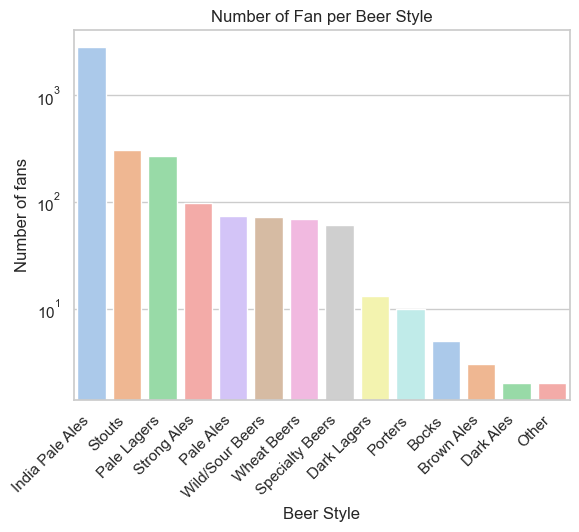

In [32]:
sns.set(style="whitegrid")
p = sns.barplot(x=histo_fans.index,y=histo_fans.values, palette='pastel', hue=histo_fans.index)
p.set_yscale("log")
plt.xticks(rotation=45, ha='right', va='top')
plt.xlabel("Beer Style")
plt.ylabel("Number of fans")
plt.title("Number of Fan per Beer Style")

In [34]:
nan_indices = fan_users_ba['location'].isnull()
fan_users_ba = fan_users_ba[~nan_indices]
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
fan_users_ba['country'] = fan_users_ba['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
fan_users_ba['fan_location_with_iso'] = fan_users_ba['country'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
fan_users_ba['fan_continent'] = fan_users_ba['country'].apply(country_to_continent)

In [35]:
# Your first plot
fig = px.choropleth(
    fan_users_ba,
    locations="fan_location_with_iso",
    color="avg_rating",
    hover_name="country",
    hover_data={"country": True, "fan_location_with_iso": False, "avg_rating": True},  # Comma added here
    projection="natural earth",
    title="Fanbase for the average ratings of IPA's around the world for RateBeer",
    color_continuous_scale='YlOrBr',
    range_color=(fan_users_ba['avg_rating'].min(), fan_users_ba['avg_rating'].max())
)

fig.update_coloraxes(colorscale="YlOrBr")

fig.show()

### For RateBeer

In [226]:
ratings_rb_f = pd.read_csv(f'{path_rb}/ratings.csv')

In [312]:
ratings_rb_f = ratings_rb_f[['style','user_id','rating']]
ratings_rb_f['bigger_style'] = ratings_rb_f['style'].apply(categorize_style)

#Only keep users that posted 5 review or more (so we don't have "fans" that posted 2 reviews)
user_review_counts = ratings_rb_f['user_id'].value_counts()
valid_users = user_review_counts[user_review_counts >= 5].index
ratings_rb_f = ratings_rb_f[ratings_rb_f['user_id'].isin(valid_users)]

In [331]:
#Start by defining the percentage of review per beer style for each users
style_percentage = ratings_rb_f.groupby(['user_id', 'bigger_style'])['rating'].count() / ratings_rb_f.groupby('user_id')['rating'].count()

#Keep only user a have one of the percentages >.75 
fan_users = style_percentage[style_percentage >= 0.75].reset_index()
 
#Identify the preferred style
fan_users = fan_users.groupby('user_id')['bigger_style'].first().reset_index()

#Enrich with informations from the first dataset
fan_users = pd.merge(fan_users, ratings_rb_f, on=['user_id', 'bigger_style'], how='left')

#Reduce to one row per user, by computing the mean grade given to preferred style
fan_users = fan_users.groupby(['user_id', 'bigger_style'])['rating'].mean().reset_index()

#Enrich with the location by merging with user df
user_loc = users_rb[['user_id', 'location']]
fan_users_rb = pd.merge(fan_users, user_loc, on = ['user_id'], how = 'left')
fan_users_rb.columns = ['user_id', 'preferred_style', 'avg_rating','location']

In [332]:
#Now we extract statistics about the users:
display(fan_users_rb['preferred_style'].value_counts())

style_avg_rating_by_fan_rb = fan_users_rb.groupby('preferred_style')['avg_rating'].mean().reset_index()
style_avg_rating_by_fan_rb['avg_rating'] = sorted(style_avg_rating_by_fan_rb['avg_rating'],reverse= True)
fan_users_rb = fan_users_rb[fan_users_rb['preferred_style'] == 'India Pale Ales'].reset_index()
display(style_avg_rating_by_fan_rb)

preferred_style
Pale Lagers        610
India Pale Ales    263
Strong Ales        180
Pale Ales          131
Stouts              37
Specialty Beers     26
Wild/Sour Beers     11
Wheat Beers         11
Dark Lagers          3
Bocks                1
Name: count, dtype: int64

,preferred_style,avg_rating
0,Bocks,4.350000
1,Dark Lagers,4.092030
2,India Pale Ales,3.951406
3,Pale Ales,3.949455
4,Pale Lagers,3.801990
5,Specialty Beers,3.603918
6,Stouts,3.354996
7,Strong Ales,3.316667
8,Wheat Beers,3.229847
9,Wild/Sour Beers,2.434818


In [342]:
def add_iso_code3(location):
    try:
        country_alpha3 = py.countries.get(name=location).alpha_3
        return f'{country_alpha3}'
    except AttributeError:
        return location

In [343]:
nan_indices = fan_users_rb['location'].isnull()
fan_users_rb = fan_users_rb[~nan_indices]
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
fan_users_rb['country'] = fan_users_rb['location'].apply(rename_country)

# Add a column for the ISO 3166 norm
fan_users_rb['fan_location_with_iso'] = fan_users_rb['country'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
fan_users_rb['fan_continent'] = fan_users_rb['country'].apply(country_to_continent)

In [126]:
# Your first plot
fig = px.choropleth(
    fan_users_rb,
    locations="fan_location_with_iso",
    color="avg_rating",
    hover_name="country",
    hover_data={"country": True, "fan_location_with_iso": False, "avg_rating": True},  # Comma added here
    projection="natural earth",
    title="Fanbase for the average ratings of IPA's around the world for RateBeer",
    color_continuous_scale='YlOrBr',
    range_color=(fan_users_rb['avg_rating'].min(), fan_users_rb['avg_rating'].max())
)

fig.update_coloraxes(colorscale="YlOrBr")

fig.show()

ValueError: Value of 'hover_name' is not the name of a column in 'data_frame'. Expected one of ['user_id', 'preferred_style', 'avg_rating', 'location'] but received: country

# Analysis of words in positive reviews

In [61]:
reviews_ba_f = pd.read_csv(f'{path_ba}/reviews.csv')

In [62]:
reviews_ba_f = reviews_ba_f.dropna(axis=0, subset='text')
reviews_ba_f = reviews_ba_f[['beer_id','user_id','style','rating','text']]
reviews_ba_f['bigger_style'] = reviews_ba_f['style'].apply(categorize_style)
reviews_ba_f = reviews_ba_f.drop(columns=['style'])

#7 million reviews to 650 000
good_reviews_ba_f =  reviews_ba_f[(reviews_ba_f['rating'] > 4)]
bad_reviews_ba_f =  reviews_ba_f[(reviews_ba_f['rating'] < 2)]

#Create a single string containing every reviews
good_reviews_str = ' '.join(good_reviews_ba_f['text'].astype(str))
bad_reviews_str = ' '.join(bad_reviews_ba_f['text'].astype(str))

stop_words = ["beer", "one", "taste", "t", "s", "pour", "pours", "poured", "quot"] + list(STOPWORDS)

#### WordCloud for good reviews

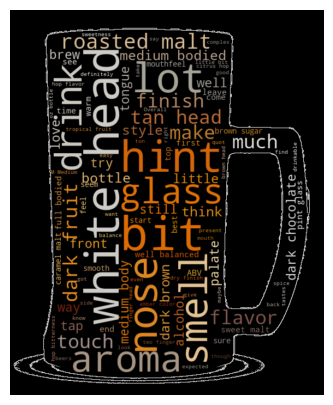

In [63]:
# Generate the word cloud
mask_beer = np.array(Image.open(f"{current_dir}/{'img/beer_mask.png'}"))
mask_beer=np.where(mask_beer == (0,0,0,0), 255, mask_beer)

wordcloud_good = WordCloud(width=400, 
                           height=800, 
                           background_color='black', 
                           mask=mask_beer,
                           max_words= 100,
                           contour_width=.1,
                           contour_color= "white",
                           stopwords=stop_words).generate(good_reviews_str)

# Generate colors so cloud has beer colors
beer_colors = ImageColorGenerator(mask_beer)
wordcloud_good.recolor(color_func = beer_colors)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.show()

#### WordCloud for bad reviews

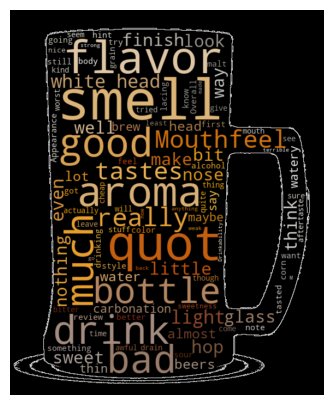

In [64]:
# Generate the word cloud
mask_beer = np.array(Image.open(f"{current_dir}/{'img/beer_mask.png'}"))
mask_beer=np.where(mask_beer == (0,0,0,0), 255, mask_beer)

stop_words = ["beer", "one", "taste", "t", "s", "pour", "pours", "poured"] + list(STOPWORDS)

wordcloud_bad = WordCloud(width=400, 
                           height=800, 
                           background_color='black', 
                           mask=mask_beer,
                           max_words= 100,
                           contour_width=.1,
                           contour_color= "white",
                           stopwords=stop_words).generate(bad_reviews_str)

# Generate colors so cloud has beer colors
beer_colors = ImageColorGenerator(mask_beer)
wordcloud_bad.recolor(color_func = beer_colors)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.show()

#### WordCloud for IPA reviews

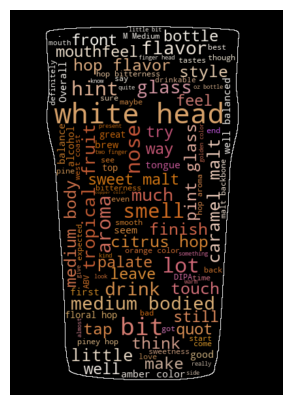

In [65]:
#Generate the string for IPA reviews
ipa_reviews = reviews_ba_f[reviews_ba_f['bigger_style'] == 'India Pale Ales']
ipa_reviews_str = ' '.join(ipa_reviews['text'].astype(str))

#Create the mask for the IPA
mask_ipa = np.array(Image.open(f"{current_dir}/{'img/ipa_mask.png'}"))
mask_ipa=np.where(mask_ipa == (0,0,0,0), 255, mask_ipa)

ipa_stop_words = stop_words + ["ipa"]


# Generate the word cloud
wordcloud_ipa = WordCloud(width=400, 
                          height=800, 
                          background_color='black',
                          mask=mask_ipa, 
                          max_words= 100,
                          contour_width=.1,
                          contour_color= "white",
                          stopwords= ipa_stop_words).generate(ipa_reviews_str)

# Generate colors so cloud has beer colors
ipa_colors = ImageColorGenerator(mask_ipa)
wordcloud_ipa.recolor(color_func = ipa_colors)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ipa, interpolation='bilinear')
plt.axis('off')
plt.show()

#### WordCloud for stouts reviews

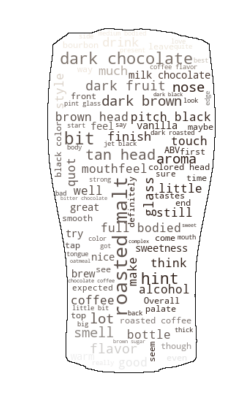

In [66]:
#Create the string for stouts
stout_reviews = reviews_ba_f[reviews_ba_f['bigger_style'] == 'Stouts']
stout_reviews_str = ' '.join(stout_reviews['text'].astype(str))

#Create the mask for the stouts
mask_stout = np.array(Image.open(f"{current_dir}/{'img/stout_mask.png'}"))
mask_stout=np.where(mask_stout == (0,0,0,0), 255, mask_stout)

stout_stop_words = stop_words + ["stout"]

# Generate the word cloud
wordcloud_stout = WordCloud(width=400, 
                            height=800, 
                            background_color='white',
                            mask=mask_stout, 
                            max_words= 100,
                            contour_width=.1,
                            contour_color= "black",
                            stopwords= stout_stop_words).generate(stout_reviews_str)

# Generate colors so cloud has beer colors
stout_colors = ImageColorGenerator(mask_stout)
wordcloud_stout.recolor(color_func = stout_colors)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_stout, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
def get_top_words(df, text_column, custom_stop_words=None, n_top_words=10):
    """
    Count the occurrences of words in a text column of a DataFrame and return the top N words.

    Parameters:
    - df: pandas DataFrame
    - text_column: str, the column containing the text data
    - custom_stop_words: list, custom stop words to be excluded from word counts
    - n_top_words: int, the number of top words to retrieve

    Returns:
    - pd.DataFrame, a DataFrame with the top N words and their counts
    """

    # Create a CountVectorizer instance with custom stop words
    vectorizer = CountVectorizer(stop_words=custom_stop_words, lowercase=True)

    # Fit and transform the text data
    X = vectorizer.fit_transform(df[text_column])

    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Sum the occurrences of each word
    word_counts = X.sum(axis=0)

    # Create a DataFrame with word counts and corresponding words
    word_counts_df = pd.DataFrame({'word': feature_names, 'count': word_counts.A1})

    # Get the top N words
    top_words = word_counts_df.nlargest(n_top_words, 'count')

    return top_words

In [68]:
# Quantitative comparison
top_words_good = get_top_words(good_reviews_ba_f, 'text', stop_words)
top_words_good.columns = ['word_good', 'good_count']

top_words_bad = get_top_words(bad_reviews_ba_f, 'text', stop_words)
top_words_bad.columns = ['word_bad', 'bad_count']

top_words_ipa = get_top_words(ipa_reviews, 'text', ipa_stop_words)
top_words_ipa.columns = ['word_ipa', 'ipa_count']

top_words_stout = get_top_words(stout_reviews, 'text', stout_stop_words)
top_words_stout.columns = ['word_stout', 'stout_count']




/Users/adrien/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.

/Users/adrien/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.

/Users/adrien/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop wo

In [69]:
# Convert DataFrames to dictionaries
dict_good = dict(zip(top_words_good['word_good'], top_words_good['good_count']))
dict_bad = dict(zip(top_words_bad['word_bad'], top_words_bad['bad_count']))
dict_ipa = dict(zip(top_words_ipa['word_ipa'], top_words_ipa['ipa_count']))
dict_stout = dict(zip(top_words_stout['word_stout'], top_words_stout['stout_count']))

# Create a new DataFrame
result_df = pd.DataFrame({'good_reviews_top_words': list(dict_good.keys()), 
                          'good_count': list(dict_good.values()),
                          'bad_reviews_top_words': list(dict_bad.keys()),
                          'bad_count': list(dict_bad.values()),
                          'ipa_reviews_top_words': list(dict_ipa.keys()), 
                          'ipa_count': list(dict_ipa.values()),
                          'stout_reviews_top_words': list(dict_stout.keys()), 
                          'stout_count': list(dict_stout.values()),
                          })

# Display the results
display(result_df)

,good_reviews_top_words,good_count,bad_reviews_top_words,bad_count,ipa_reviews_top_words,ipa_count,stout_reviews_top_words,stout_count
0,head,958340,head,23364,hops,474274,chocolate,430829
1,nice,773231,light,19722,head,414921,dark,367979
2,good,608726,quot,16327,hop,338873,coffee,360571
3,dark,585969,smell,14204,nice,330469,head,303552
4,sweet,568938,bottle,13099,citrus,321717,black,258506
5,malt,560709,good,12360,malt,311277,roasted,216729
6,light,559784,flavor,11989,good,301976,nice,191504
7,hops,558642,sweet,11330,orange,245643,good,181297
8,well,524882,bad,11233,white,222329,sweet,168930
9,carbonation,480083,much,11140,light,221703,brown,157774


# Microbrewries and craft beer impact in the trend 

## For BA

In [8]:
reviews_ba_f = reviews_ba[['beer_id','user_id','style','rating','text','date']]

#  Convert the date to the right format 
reviews_ba_f['date'] = convert_to_date(reviews_ba_f['date'])

# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
reviews_ba_f['date'] = pd.to_datetime(reviews_ba_f['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')


#drop NaNs
reviews_ba_f = reviews_ba_f.dropna(axis=0, subset='text')
reviews_ba_f = reviews_ba_f.dropna(axis=0, subset='date')


reviews_ba_f['bigger_style'] = reviews_ba_f['style'].apply(categorize_style)
reviews_ba_f = reviews_ba_f.drop(columns=['style'])

ipa_reviews = reviews_ba_f[reviews_ba_f['bigger_style'] == 'India Pale Ales']
stout_reviews = reviews_ba_f[reviews_ba_f['bigger_style'] == 'Stouts']


NameError: name 'reviews_ba' is not defined

In [116]:
# Initialize DataFrame
reviews_ba_f['date'] = pd.to_datetime(reviews_ba_f['date'])

# Initialize sets to track unique reviews for each keyword
keywords = ['local','locally', 'small business', 'homemade','microbrewery', 'brewpub', 'micro', 'draft']
review_sets = {keyword: set() for keyword in keywords}

# Count occurrences and store in DataFrame
for keyword in review_sets:
    mask = reviews_ba_f['text'].str.contains(rf'\b(?:{keyword})\b', case=False, regex=True)
    new_reviews = mask & ~reviews_ba_f['text'].isin(review_sets[keyword])
    review_sets[keyword].update(reviews_ba_f.loc[new_reviews, 'text'])
    reviews_ba_f[f'{keyword}_count'] = new_reviews.astype(int)

    # Print total number of comments mentioning each keyword
    total_comments = sum(mask)
    print(f"Total comments mentioning '{keyword}': {total_comments}")


# Group by 'date' and sum the counts for each keyword
reviews_ba_grouped = reviews_ba_f.groupby('date').agg({f'{keyword}_count': 'sum' for keyword in keywords}).reset_index()

# Calculate total count and add a 'total' column to the DataFrame
reviews_ba_grouped['total_count'] = reviews_ba_grouped[[f'{keyword}_count' for keyword in keywords]].sum(axis=1)
print(f"Total comments mentioning all the keywords': {reviews_ba_grouped['total_count']}")



Total comments mentioning 'local': 42997
Total comments mentioning 'locally': 4829
Total comments mentioning 'small business': 14
Total comments mentioning 'homemade': 1629
Total comments mentioning 'microbrewery': 690
Total comments mentioning 'brewpub': 19135
Total comments mentioning 'micro': 6076
Total comments mentioning 'draft': 30126


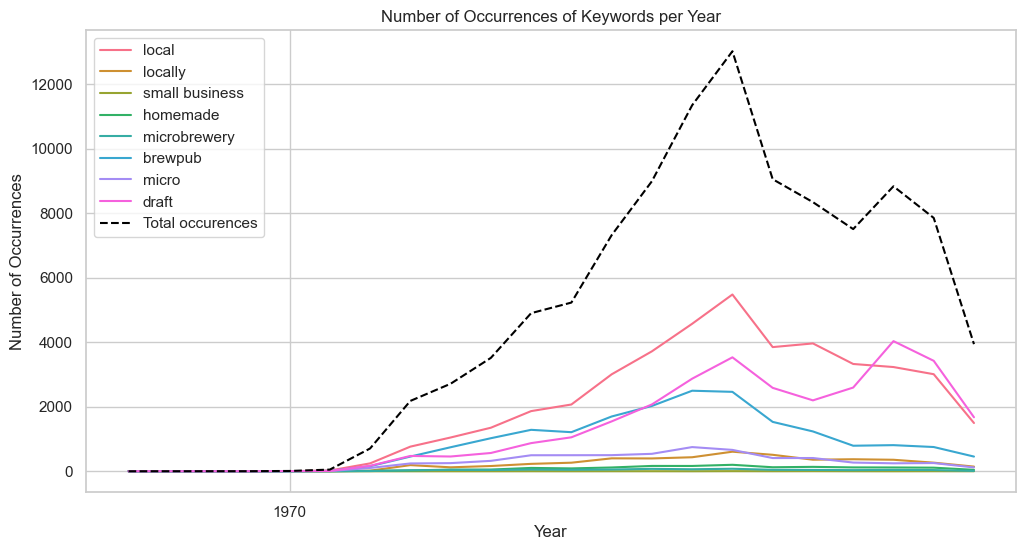

In [120]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

palette = sns.color_palette("husl", n_colors=len(keywords))

for keyword, color in zip(keywords, palette):
    sns.lineplot(x='date', y=f'{keyword}_count', data=reviews_ba_grouped, label=keyword, color=color)

# Plot the total curve
sns.lineplot(x='date', y='total_count', data=reviews_ba_grouped, label='Total occurences', color='black', linestyle='--')


plt.title('Number of Occurrences of Keywords per Year')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.show()

Should we use the total occurence of these words as a metric ?

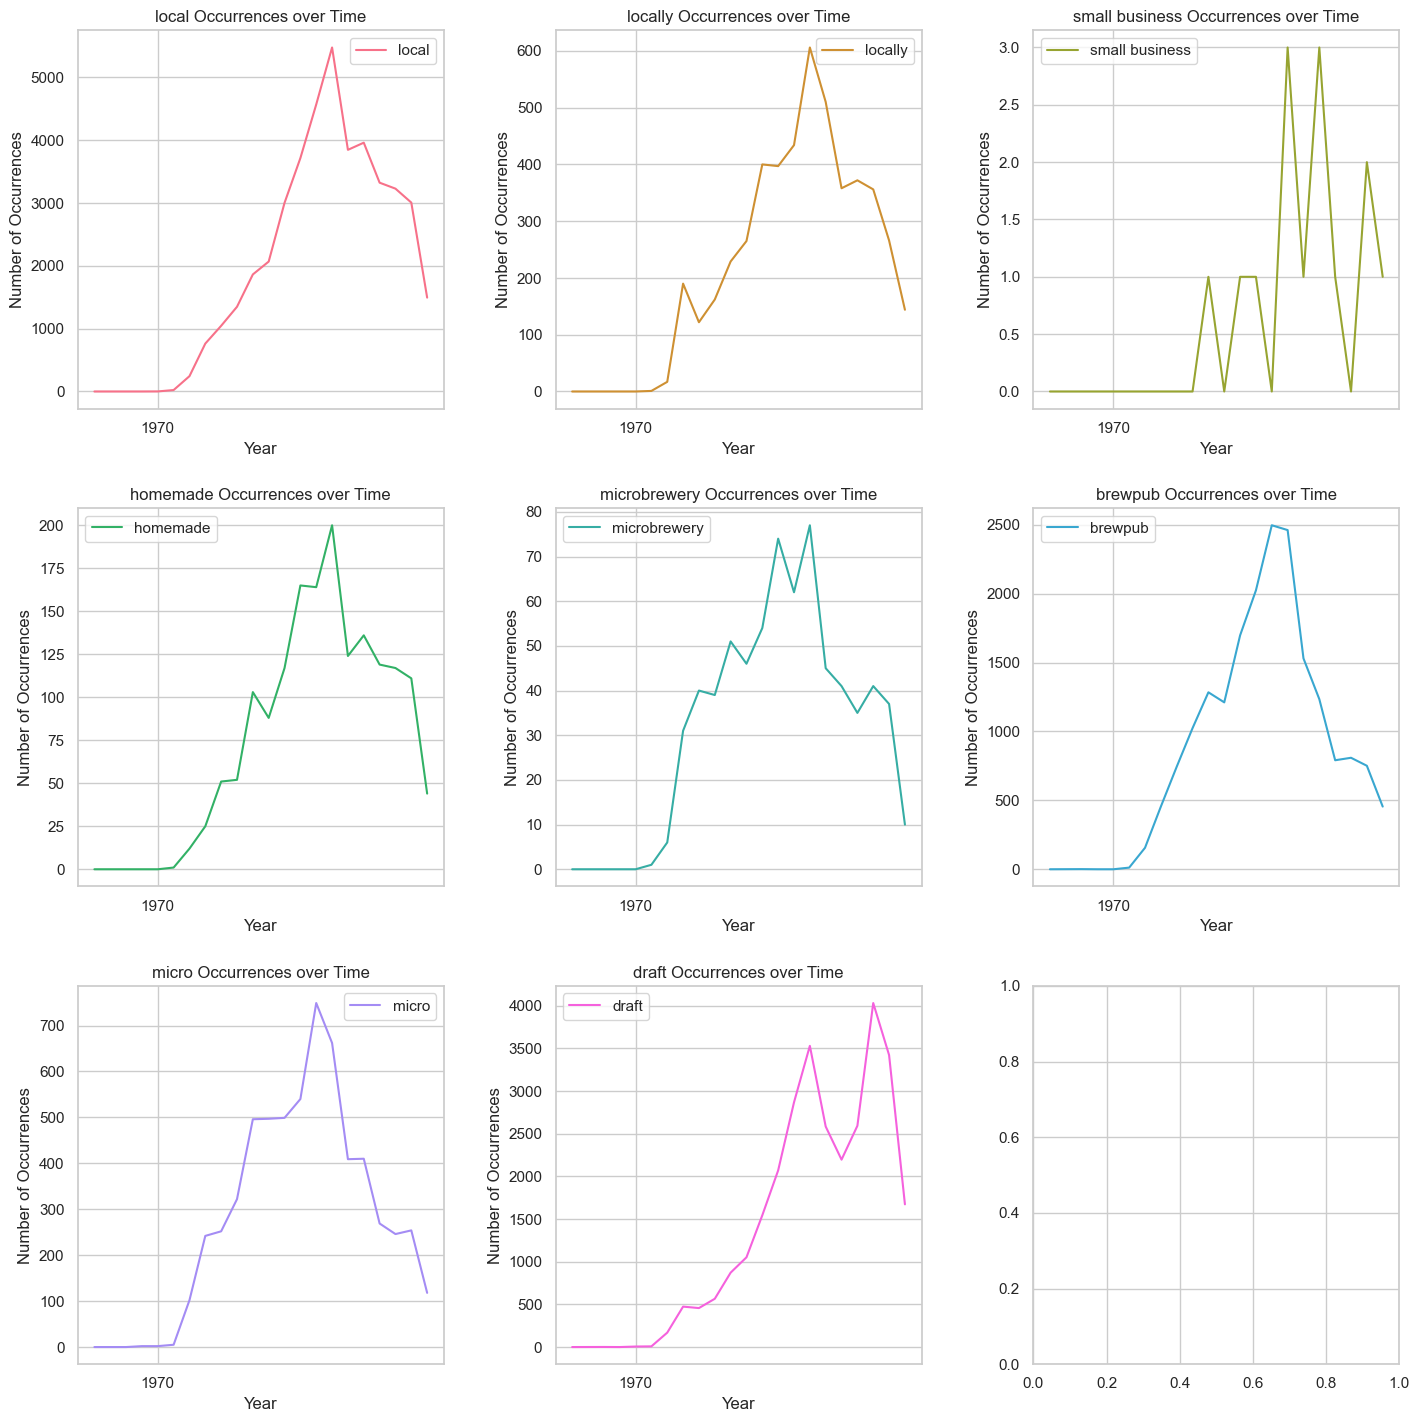

In [128]:
# Plot occurrences of each word without mdates and MaxNLocator using the same color palette
fig, axes = plt.subplots(nrows=len(keywords)//3 + 1, ncols=3, figsize=(15, 15))
fig.tight_layout(pad=4.0)
for i, keyword in enumerate(keywords):
    row, col = divmod(i, 3)
    sns.lineplot(x='date', y=f'{keyword}_count', data=reviews_ba_grouped, label=keyword, ax=axes[row, col], color=palette[i])
    axes[row, col].set_title(f'{keyword} Occurrences over Time')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Number of Occurrences')

plt.show()

Trying to correlate IPA popularity gain with microbreweries

marche pas encore, need to define IPA_popularity

In [ ]:
# Step 1: Merge DataFrames
merged_df = pd.merge(reviews_ba_grouped, ipa_popularity, on='date', how='inner')

# Step 2: Calculate Correlation
correlation_matrix = merged_df[['local_count', 'small_count', 'microbrewery_count', 'brewpub_count', 'micro_count', 'draft_count', 'popularity']].corr()

# Step 3: Visualize the Correlation Matrix with Coefficients
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()


# Geographical analysis

## BeerAdvocate

### Preprocess

In [12]:
ratings_ba_f = pd.read_csv(f'{path_ba}/ratings.csv')

In [13]:
ratings_ba_f_drop = ratings_ba_f.drop(columns=['beer_name', 'brewery_id','brewery_name','style','abv','user_name', 
                                                'appearance', 'rating', 'aroma', 'palate', 'taste', 'overall', 'text', 'review'])

users_ba_f_drop = users_ba_f.drop(columns=['nbr_reviews', 'user_name', 'joined'])
users_ba_f_drop = users_ba_f_drop.rename(columns={'location': 'user_location'})

ratings_users_ba = pd.merge(ratings_ba_f_drop, users_ba_f_drop, on='user_id')

ba_beer_brewery_drop = ba_beer_brewery.drop(columns=['brewery_id', 'brewery_name', 'nbr_reviews',
                                                           'bros_score', 'abv', 'id', 'name', 'nbr_ratings'])

beer_user_ba = pd.merge(ratings_users_ba, ba_beer_brewery_drop, on='beer_id')

In [14]:
beer_user_ba.dropna(subset=['user_location'], inplace=True)

In [15]:
def add_iso_code3(location):
    try:
        country_alpha3 = py.countries.get(name=location).alpha_3
        return f'{country_alpha3}'
    except AttributeError:
        return location

In [16]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
beer_user_ba['user_location_grouped'] = beer_user_ba['user_location'].apply(rename_country)

# Add a column for the ISO 3166 norm
beer_user_ba['user_location_with_iso'] = beer_user_ba['user_location_grouped'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
beer_user_ba['user_continent'] = beer_user_ba['user_location_grouped'].apply(country_to_continent)

In [17]:
# Convert the date to the right format 
beer_user_ba['date'] = convert_to_date(beer_user_ba['date'])

# Extract only the year from the 'date' column (assuming 'date' is already in datetime format)
beer_user_ba['date'] = pd.to_datetime(beer_user_ba['date'], errors='coerce', format='%Y-%m-%d', utc=True).dt.year.astype('Int32')

# Create the bigger styles of beer column 
beer_user_ba['bigger_style'] = beer_user_ba['style'].apply(categorize_style)

# Beers that have a score (range 0-100) > to the 3rd quartile
ba_style_year_filtered = beer_user_ba[beer_user_ba['ba_score'] >= beer_user_ba['ba_score'].quantile(0.75)]

# Beers that have an average grade (range 0-5) > to the 3rd quartile
ba_style_year_filtered = ba_style_year_filtered[ba_style_year_filtered['avg'] >= ba_style_year_filtered['avg'].quantile(0.75)]

In [18]:
grouped_style_ba = aggregate_data(ba_style_year_filtered, 'style', 'user_location')

grouped_Bstyle_ba = aggregate_data(ba_style_year_filtered, 'bigger_style', 'user_location')

In [19]:
# Compute the total number of ratings per year
total_ratings_per_year_ba = pd.DataFrame(ba_style_year_filtered.groupby('date').count()["beer_id"])
total_ratings_per_year_ba = total_ratings_per_year_ba.rename(columns={"beer_id": "total_nbr_ratings"})

### Numbers of ratings per year for each bigger style of beer

<Figure size 1200x800 with 0 Axes>

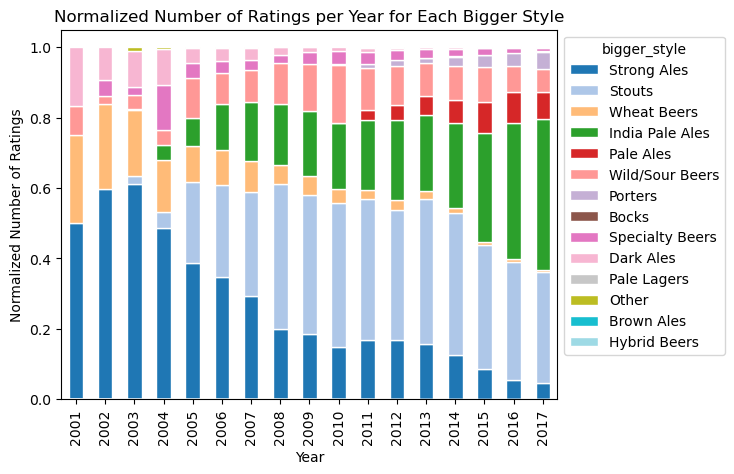

In [22]:
plot_normalized_ratings_by_group(grouped_Bstyle_ba, 'bigger_style', 'Normalized Number of Ratings per Year for Each Bigger Style', total_ratings_per_year_ba)

### Plot / compute the numbers of ratings / year / bigger_style

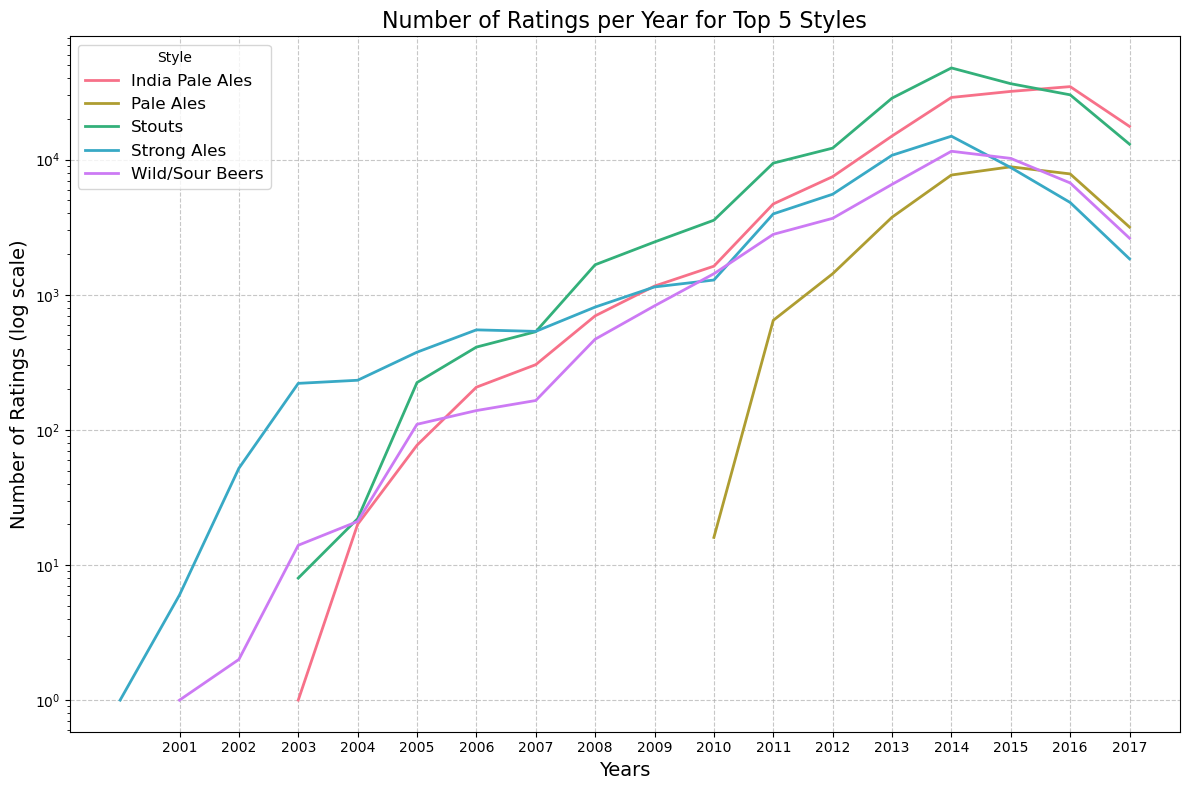

Mean Increase for each style per year:
Mean Increase for India Pale Ales: 217.70%
Mean Increase for Pale Ales: 610.90%
Mean Increase for Stouts: 129.22%
Mean Increase for Strong Ales: 120.00%
Mean Increase for Wild/Sour Beers: 107.95%

------------------------------------------------------

Mean Increase for each style between first year and last year:
Mean Increase for India Pale Ales: 117460.00%
Mean Increase for Pale Ales: 39412.50%
Mean Increase for Stouts: 86726.67%
Mean Increase for Strong Ales: 10238.89%
Mean Increase for Wild/Sour Beers: 15417.65%


In [20]:
# Calculate the sum of ratings for each style
style_ratings_sum = grouped_Bstyle_ba.groupby("bigger_style")["nbr_ratings"].sum()

# Select the top 5 styles with the highest number of ratings
top_styles = style_ratings_sum.nlargest(5).index
top_styles = sorted(top_styles)

# Create a stylish line plot for the top 5 styles using seaborn
plt.figure(figsize=(12, 8))

# Set a color palette for better distinction between styles
palette = sns.color_palette("husl", n_colors=len(top_styles))

mean_increase_list_per_year = []
mean_increase_y1_yf_list = []

for style, color in zip(top_styles, palette):
    # Extract information for the current style
    style_data = grouped_Bstyle_ba[grouped_Bstyle_ba["bigger_style"] == style]["ratings_info"].iloc[0]
    years = list(style_data.keys())
    years_int = [int(year) for year in years]
    nbr_ratings = [style_data[year]['nbr_ratings'] for year in years]

    # Calculate the mean increase between the first and last year
    mean_increase_y1_yf = (nbr_ratings[-1] - nbr_ratings[0]) / (len(nbr_ratings))
    mean_increase_y1_yf_list.append(mean_increase_y1_yf)

    # Calculate the mean increase per year 
    mean_increase_per_year = sum([(nbr_ratings[i] - nbr_ratings[i - 1]) / nbr_ratings[i - 1] 
                         for i in range(1, len(nbr_ratings))]) / (len(nbr_ratings) - 1)
    mean_increase_list_per_year.append(mean_increase_per_year)

    # Plot the data as a smooth line
    sns.lineplot(x=years_int, y=nbr_ratings, label=style, color=color, linewidth=2)

# Customize plot details
plt.title('Number of Ratings per Year for Top 5 Styles', fontsize=16)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Number of Ratings (log scale)', fontsize=14)
plt.yscale('log')
plt.legend(title='Style', loc='upper left', fontsize=12)
plt.xticks(years_int)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print mean increase for each style
print(f"Mean Increase for each style per year:")
for style, increase in zip(top_styles, mean_increase_list_per_year):
    print(f"Mean Increase for {style}: {increase:.2%}")
    
print("\n------------------------------------------------------")

# Print mean increase for each styke between the first year and last year 
print(f"\nMean Increase for each style between first year and last year:")
for style, increase in zip(top_styles, mean_increase_y1_yf_list):
    print(f"Mean Increase for {style}: {increase:.2%}")

### Number of ratings per location for each year 

#### IPA prep

In [21]:
grouped_Bstyle_ba = aggregate_data(ba_style_year_filtered, 'bigger_style', 'user_location_grouped')

# Only select the data for IPA 
ipa_data = grouped_Bstyle_ba.query('bigger_style == "India Pale Ales"')

#  Flatten the nested 'locations' data in 'grouped_beer'
flattened_locations_ba = []

for beer_data in ipa_data["ratings_info"]:
    years = list(beer_data.keys())[:-1]
    
    for year in years:
        locations_data = beer_data[year]['locations']
        
        for location, location_info in locations_data.items():
            nbr_ratings = int(location_info['nbr_ratings'])
            
            flattened_locations_ba.append({
                'year': int(year),
                'location': location,
                'country': location,
                'nbr_ratings': nbr_ratings
            })

# Convert the flattened data to a DataFrame
df_locations_ba_ipa = pd.DataFrame(flattened_locations_ba)

In [22]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
df_locations_ba_ipa['country'] = df_locations_ba_ipa['country'].apply(rename_country)
df_locations_ba_ipa = df_locations_ba_ipa.groupby(['year', 'country']).agg({'nbr_ratings': 'sum'}).reset_index()
df_locations_ba_ipa['log_nbr_ratings'] = np.log1p(df_locations_ba_ipa['nbr_ratings'])  # Use np.log1p to handle potential zero values

# Add a column for the ISO 3166 norm
df_locations_ba_ipa['location_with_iso'] = df_locations_ba_ipa['country'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
df_locations_ba_ipa['continent'] = df_locations_ba_ipa['country'].apply(country_to_continent)


#### Stouts prep

In [ ]:
# Only select the data for Stouts 
stout_data = grouped_Bstyle_ba.query('bigger_style == "Stouts"')

grouped_Bstyle_ba = aggregate_data(ba_style_year_filtered, 'bigger_style', 'user_location_grouped')

# Only select the data for Stouts 
stout_data = grouped_Bstyle_ba.query('bigger_style == "Stouts"')

#  Flatten the nested 'locations' data in 'grouped_beer'
flattened_locations_ba = []

for beer_data in stout_data["ratings_info"]:
    years = list(beer_data.keys())[:-1]
    
    for year in years:
        locations_data = beer_data[year]['locations']
        
        for location, location_info in locations_data.items():
            nbr_ratings = int(location_info['nbr_ratings'])
            
            flattened_locations_ba.append({
                'year': int(year),
                'location': location,
                'country': location,
                'nbr_ratings': nbr_ratings
            })

# Convert the flattened data to a DataFrame
df_locations_ba_stouts = pd.DataFrame(flattened_locations_ba)

In [ ]:
# Rename the countries that don't have the right format to be converted into ISO 3166 norm
df_locations_ba_stouts['country'] = df_locations_ba_stouts['country'].apply(rename_country)
df_locations_ba_stouts = df_locations_ba_stouts.groupby(['year', 'country']).agg({'nbr_ratings': 'sum'}).reset_index()
df_locations_ba_stouts['log_nbr_ratings'] = np.log1p(df_locations_ba_stouts['nbr_ratings']) 

# Add a column for the ISO 3166 norm
df_locations_ba_stouts['location_with_iso'] = df_locations_ba_stouts['country'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
df_locations_ba_stouts['continent'] = df_locations_ba_stouts['country'].apply(country_to_continent)

#### Plots IPA / Stouts 

In [23]:
# Your first plot
fig1 = px.choropleth(
    df_locations_ba_ipa,
    locations="location_with_iso",
    color="log_nbr_ratings",
    hover_name="country",
    hover_data={"country": True, "location_with_iso": False, "nbr_ratings": True, "log_nbr_ratings": False},
    animation_frame="year",
    projection="natural earth",
    #title="Number of ratings for the IPA's around the world for BeerAdvocate (Log Scale)",
    color_continuous_scale='YlOrBr',
    range_color=(df_locations_ba_ipa['log_nbr_ratings'].min(), df_locations_ba_ipa['log_nbr_ratings'].max())
)
# Update layout to set the width to 700 pixels
fig1.update_layout(width=700, height=600)
# Sauvegarde de la figure en tant que fichier HTML

fig1.update_coloraxes(colorscale="YlOrBr")

# # Your second plot
# fig2 = px.choropleth(
#     df_locations_ba_stouts,
#     locations="location_with_iso",
#     color="log_nbr_ratings",
#     hover_name="country",
#     hover_data={"country": True, "location_with_iso": False, "nbr_ratings": True, "log_nbr_ratings": False},
#     animation_frame="year",
#     projection="natural earth",
#     title="Number of ratings for the Stouts around the world for BeerAdvocate (Log Scale)",
#     color_continuous_scale='YlOrBr',
#     range_color=(df_locations_ba_stouts['log_nbr_ratings'].min(), df_locations_ba_stouts['log_nbr_ratings'].max())
# )

# fig2.update_coloraxes(colorscale="YlOrBr")

# Show the figures
fig1.show()
# fig2.show()

html_file_path = "plot/ba_IPA_worldmap_700px.html"
pyo.plot(fig1, filename=html_file_path)

'plot/ba_IPA_worldmap_700px.html'

### IPA's number of ratings focused on the States of the USA

In [146]:
us_states = gpd.read_file('cb_2021_us_state_500k/cb_2021_us_state_500k.shp')

# If your geometry is a Polygon, you can extract the centroid
us_states['centroid'] = us_states['geometry'].centroid

# Extract latitude and longitude from the centroid
us_states['latitude'] = us_states['centroid'].y
us_states['longitude'] = us_states['centroid'].x

# Drop the 'centroid' column if you no longer need it
us_states = us_states.drop(columns=['centroid'])

C:\Users\thibh\AppData\Local\Temp\ipykernel_10452\1539268515.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [186]:
grouped_beer_ba = aggregate_data(ba_style_year_filtered, 'beer_id', 'user_location')

# Only select the data for IPA 
ipa_data2 = grouped_beer_ba.query('bigger_style == "India Pale Ales"')

#  Flatten the nested 'locations' data in 'grouped_beer'
flattened_locations_ba = []

for beer_data in ipa_data2["ratings_info"]:
    years = list(beer_data.keys())
    
    for year in years:
        locations_data = beer_data[year]['locations']
        
        for location, location_info in locations_data.items():
            nbr_ratings = int(location_info['nbr_ratings'])
            
            flattened_locations_ba.append({
                'year': int(year),
                'location': location,
                'country': location,
                'nbr_ratings': nbr_ratings
            })

# Convert the flattened data to a DataFrame
df_locations_ba_ipa2 = pd.DataFrame(flattened_locations_ba)

# Rename the countries that don't have the right format to be converted into ISO 3166 norm
df_locations_ba_ipa2['country'] = df_locations_ba_ipa2['country'].apply(rename_country)
df_locations_ba_ipa2 = df_locations_ba_ipa2.groupby(['year', 'location', 'country']).agg({'nbr_ratings': 'sum'}).reset_index()

# Add a column for the ISO 3166 norm
df_locations_ba_ipa2['location_with_iso'] = df_locations_ba_ipa2['country'].apply(add_iso_code3)

# Convert every country into its corresponding continent into a new column 'continent'
df_locations_ba_ipa2['continent'] = df_locations_ba_ipa2['country'].apply(country_to_continent)

In [149]:
# Replace 'location' with your actual column name containing state names
states_data = df_locations_ba_ipa2['location'].str.split(', ', expand=True)
df_states = df_locations_ba_ipa2.copy()
df_states['NAME'] = states_data[1]  # Assuming the state names are in the second part of the location

merged_states_ba = pd.merge(us_states, df_states, on='NAME')

In [225]:
fig = go.Figure()
limits = [(0, 99), (100, 399), (400, 999), (1000, 2000), (2001, 6000)]
colors = ["black", "orange", "crimson", "forestgreen", "royalblue"]
scale = 20
years = sorted(merged_states_ba['year'].unique())[:-1]
frames = []
# Iterate through each year
for year in years:
    df_year = merged_states_ba[merged_states_ba['year'] == year]
    frame_data = []
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = merged_states_ba[(merged_states_ba['year'] == year) & (merged_states_ba['nbr_ratings'].between(lim[0], lim[1]))]
        frame_data.append(go.Scattergeo(
            locationmode='USA-states',
            lon=df_sub['longitude'],
            lat=df_sub['latitude'],
            marker=dict(
                size=df_sub['nbr_ratings'] / scale,
                color=colors[i],
                line_color='rgb(40,40,40)',
                line_width=0.5,
                sizemode='area'
            ),
            name='{0} - {1}'.format(lim[0], lim[1]),
            text=df_sub['nbr_ratings'].astype(str) + ' - ' + df_sub['NAME'],
        ))
    frames.append(go.Frame(data=frame_data, name=str(year)))
# Create scatter plots for the initial year
initial_year = years[0]
df_initial_year = merged_states_ba[merged_states_ba['year'] == initial_year]
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_initial_year[df_initial_year['nbr_ratings'].between(lim[0], lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=df_sub['longitude'],
        lat=df_sub['latitude'],
        marker=dict(
            size=df_sub['nbr_ratings'] / scale,
            color=colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode='area'
        ),
        name='{0} - {1}'.format(lim[0], lim[1]),
        text=df_sub['nbr_ratings'].astype(str) + ' - ' + df_sub['NAME'],
    ))
# Update layout for animation and dropdown menu
fig.update_layout(
    title_text='US City Number of Ratings for IPA by State (2003-2016)',
    showlegend=True,
    geo=dict(
        scope='usa',
        landcolor='rgb(217, 217, 217)',
    ),
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'visible': True,
            'prefix': 'Year:',
            'suffix': '',
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [{
            'args': [
                [str(year)],
                {
                    'frame': {'duration': 500, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 300}
                },
            ],
            'label': str(year),
            'method': 'animate',
        } for year in years],
    }],
    updatemenus=[{
        'buttons': [{
            'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
            'label': 'Play',
            'method': 'animate',
        }, {
            'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
            'label': 'Pause',
            'method': 'animate',
        }],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top',
    }],
)
# Add frames to the figure
fig.frames = frames
# Show the figure
fig.show()